In [1]:
# imports

import gdown
import zipfile
import os
import csv
import re
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from collections import defaultdict
import masserstein
from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions
from matplotlib import pyplot as plt

import pulp as pl
from pulp import mosek
from pulp import highspy
import gurobipy as gp

params = {
"WLSACCESSID": '780bdceb-b40e-4aac-ada9-80d75e41ac7f',
"WLSSECRET": '1ed95e7f-85a9-4a02-91b1-0cc2301f2bf8',
"LICENSEID": 2659108,
}
env = gp.Env(params=params)

Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659108
Academic license 2659108 - for non-commercial use only - registered to am___@student.uw.edu.pl


In [ ]:
# zadanie 1.2

# pobieranie bazy HMDB z Google Drive

folder_url = "https://drive.google.com/drive/folders/13pIHIdpC1ZMMGrwvOOP1FaAlLNA2-4C5"

output_path = r"C:\Users\agnie\Desktop\biolsys\Projekt 4\data"

gdown.download_folder(url=folder_url, output=output_path)

Retrieving folder contents


Processing file 1iSlEAXxQri8ec1vOvjFPZD2WdrOKRLx8 hmdb_nmr_spectra_1.zip
Processing file 1lVZFt2TE5Nei0n1BAncd8itQQP4N4Xnw hmdb_nmr_spectra_2.zip
Processing file 12B8o_9IdwSpR2LVgZVqqwE6QdgruZItp hmdb_nmr_spectra_3.zip
Processing file 1P4frTOUZVb-iW9JL6cqkO7rBQ6JLM7lX hmdb_nmr_spectra_4.zip
Processing file 1KiXBQxw5Z164ZFqL2pyJIu_ry2EfV-2J hmdb_nmr_spectra_5.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1iSlEAXxQri8ec1vOvjFPZD2WdrOKRLx8
From (redirected): https://drive.google.com/uc?id=1iSlEAXxQri8ec1vOvjFPZD2WdrOKRLx8&confirm=t&uuid=9d9d62be-1bd9-4b1e-a65f-051dd85ba610
To: C:\Users\agnie\Desktop\biolsys\Projekt 4\data\hmdb_nmr_spectra_1.zip
100%|██████████| 226M/226M [00:28<00:00, 7.83MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1lVZFt2TE5Nei0n1BAncd8itQQP4N4Xnw
From (redirected): https://drive.google.com/uc?id=1lVZFt2TE5Nei0n1BAncd8itQQP4N4Xnw&confirm=t&uuid=b3541261-d1d2-4689-a92f-13729930c872
To: C:\Users\agnie\Desktop\biolsys\Projekt 4\data\hmdb_nmr_spectra_2.zip
100%|██████████| 169M/169M [00:19<00:00, 8.70MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=12B8o_9IdwSpR2LVgZVqqwE6QdgruZItp
From (redirected): https://drive.google.com/uc?id=12B8o_9IdwSpR2LVgZVqqwE6QdgruZIt

['C:\\Users\\agnie\\Desktop\\biolsys\\Projekt 4\\data\\hmdb_nmr_spectra_1.zip',
 'C:\\Users\\agnie\\Desktop\\biolsys\\Projekt 4\\data\\hmdb_nmr_spectra_2.zip',
 'C:\\Users\\agnie\\Desktop\\biolsys\\Projekt 4\\data\\hmdb_nmr_spectra_3.zip',
 'C:\\Users\\agnie\\Desktop\\biolsys\\Projekt 4\\data\\hmdb_nmr_spectra_4.zip',
 'C:\\Users\\agnie\\Desktop\\biolsys\\Projekt 4\\data\\hmdb_nmr_spectra_5.zip']

In [ ]:
# rozpakowywanie plików zip z bazy HMDB

zip_folder = r"C:\Users\agnie\Desktop\biolsys\Projekt 4\data"
result = r"C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data"


for filename in os.listdir(zip_folder):

  zip_path = os.path.join(zip_folder, filename)
  folder_name = os.path.splitext(filename)[0]
  extract_to = os.path.join(result, folder_name)

  if zip_path.endswith(".zip"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to)
      print(f"Successfully extracted {filename} to {extract_to}")

Successfully extracted hmdb_nmr_spectra_1.zip to C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_1
Successfully extracted hmdb_nmr_spectra_2.zip to C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_2
Successfully extracted hmdb_nmr_spectra_3.zip to C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_3
Successfully extracted hmdb_nmr_spectra_4.zip to C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_4
Successfully extracted hmdb_nmr_spectra_5.zip to C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_5


In [ ]:
# zadanie 1.3

def extract_1D_spectra(folder_path: str, nucleus: str):

  for filename in os.listdir(folder_path):

    if filename.endswith(".xml"):

      file_path = os.path.join(folder_path, filename)
      try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        # typ danych
        if root.tag != "nmr-one-d":
          continue # pomiń jeśli dane nie 1D

        # Pobranie HMDB ID
        hmdb_id = root.findtext(".//database-id")
        if hmdb_id is None:
          print('BŁĄD 1')


        # Pobranie częstotliwości
        raw_freq = root.findtext(".//frequency").strip()
        match = re.search(r"[\d.]+", raw_freq)

        if match:
          frequency = int(float(match.group()))
        else:
          frequency = 'unknown' # jeśli nie można znaleźć częstotliwości


        # Pobranie Spectrum ID
        spectrum_id = root.findtext(".id")
        if spectrum_id is None:
          print('BŁĄD 3')

        # Jądro
        spectrum_nucleus = root.findtext(".//nucleus")
        if spectrum_nucleus != nucleus:
          pass # pomiń plik, jeśli jądro się nie zgadza

        # Typ danych
        predicted_elem = root.find(".//predicted")
        if predicted_elem is not None:
          if predicted_elem.attrib.get("nil") == "true":
            source_type = "experimental"
          elif predicted_elem.text == "true":
            source_type = "predicted"
        else:
          print('BŁĄD 5')

        # znajdowanie pików
        peaks = root.find("nmr-one-d-peaks")
        if peaks is None:
          print('BŁĄD 6')

        shifts = [p.text for p in peaks.findall(".//chemical-shift")]
        peak_positions = [p.text for p in peaks.findall(".//peak-position-ppm")]
        intensities = [p.text for p in peaks.findall(".//intensity")]

        if (shifts is None) or (intensities is None) or (peak_positions is None):
          print('BŁĄD 7')

        # zapisywanie wyniku do pliku CSV
        output_filename = f"{hmdb_id}_1D_{spectrum_id}_{source_type}_{nucleus}_{frequency}.csv"
        output_path = os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\parsed data", output_filename)

        with open(output_path, "w", newline="") as csvfile:
          writer = csv.writer(csvfile)
          writer.writerow(["chemical_shift", "peak_position_ppm", "intensity"])
          for shift, intensity, peak_position in zip(shifts, peak_positions, intensities):
            writer.writerow([shift, intensity, peak_position])


      except ET.ParseError:
        print(f"Błąd parsowania: {filename}")


In [ ]:
# przetwarzanie plików z katalogów hmdb_nmr_spectra_1 do hmdb_nmr_spectra_5
for i in range(1, 6):
    extract_1D_spectra(fr"C:\Users\agnie\Desktop\biolsys\Projekt 4\unzipped data\hmdb_nmr_spectra_{i}\hmdb_nmr_spectra_{i}", "1H")
    print(f"Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_{i}")

Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_1
Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_2
Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_3
Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_4
Zakończono przetwarzanie plików z katalogu hmdb_nmr_spectra_5


In [ ]:
# zadanie 1.4

def preprocess_1D_spectra(filename:str, out_folder="./Preprocessed", sig=None):
    df = pd.read_csv(filename)
    stripname = os.path.splitext(os.path.basename(filename))[0]

    # zaookrąglanie do liczb znaczących
    if sig is not None:
        df["peak_position_ppm"] = df["peak_position_ppm"].apply(lambda x: round(x, sig - int(np.floor(np.log10(abs(x)))) - 1))

    # grupowanie po peak_position_ppm
    grouped = df.groupby("peak_position_ppm")["intensity"].sum().reset_index()

    # zapisywanie wyniku do pliku CSV
    os.makedirs(out_folder, exist_ok=True)
    out_path = os.path.join(out_folder, f"{stripname}_processed.csv")
    grouped.to_csv(out_path, index=False)

In [ ]:
# preprocessing danych z HMDB

for filename in os.listdir(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\parsed data"):
    path= os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\parsed data", filename)

    preprocess_1D_spectra(filename=path)

In [ ]:
# zadanie 1.6

# dane pobrane z HMDB
detected = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\metabolites-Detected.csv")['HMDB_ID'].tolist()
detected_quantified = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\metabolites-Detected and quantified.csv")['HMDB_ID'].tolist()
detected_not_quantified = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\metabolites-Detected but not quantified.csv")['HMDB_ID'].tolist()

detected_count = 0
detected_quantified_count = 0
detected_not_quantified_count = 0

files = os.listdir(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed")

for file in files:
    if file.split('_')[3] == 'experimental': # tylko pliki z danymi eksperymentalnymi
        if file.split('_')[0] in detected:
            detected_count += 1
        if file.split('_')[0] in detected_quantified:
            detected_quantified_count += 1
        if file.split('_')[0] in detected_not_quantified:
            detected_not_quantified_count += 1

print(f"Liczba metabolitów z danymi eksperymentalnymi: {detected_count}")
print(f"Liczba metabolitów z danymi eksperymentalnymi i skwantyfikowanymi: {detected_quantified_count}")
print(f"Liczba metabolitów z danymi eksperymentalnymi ale nie skwantyfikowanymi: {detected_not_quantified_count}")

Liczba metabolitów z danymi eksperymentalnymi: 1843
Liczba metabolitów z danymi eksperymentalnymi i skwantyfikowanymi: 1607
Liczba metabolitów z danymi eksperymentalnymi ale nie skwantyfikowanymi: 236


In [ ]:
# zadanie 1.7

df = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Data_urine\Data_urine\selected_metabolites.csv")
names = df["HMDB.ca ID"].dropna().astype(str).unique()

predicted_frequencies = dict.fromkeys(names, []) # częstotliwości z danych przewidywanych
is_experimental = dict.fromkeys(names, False) # czy metabolit ma dane eksperymentalne

files = os.listdir(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed")

for file in files:

    if file.split('_')[0] in names:
        if file.split('_')[3] == 'experimental':
            is_experimental[file.split('_')[0]] = True

        if file.split('_')[3] == 'predicted':
            predicted_frequencies[file.split('_')[0]].append(int(file.split('_')[5]))

print("Liczba metabolitów z danymi eksperymentalnymi:", sum(is_experimental.values()))

print("Najwyższe częstotliwości dla metabolitów z danymi przewidywanymi:")
for name, freqs in predicted_frequencies.items():
    if is_experimental[name] and freqs is not None:
        print(f"{name}: {max(freqs)} MHz")

Liczba metabolitów z danymi eksperymentalnymi: 26
Najwyższe częstotliwości dla metabolitów z danymi przewidywanymi:
HMDB0000023: 1000 MHz
HMDB0000754: 1000 MHz
HMDB0000190: 1000 MHz
HMDB0000161: 1000 MHz
HMDB0000042: 1000 MHz
HMDB0000812: 1000 MHz
HMDB0011635: 1000 MHz
HMDB0000254: 1000 MHz
HMDB0000094: 1000 MHz
HMDB0000087: 1000 MHz
HMDB0000906: 1000 MHz
HMDB0003911: 1000 MHz
HMDB0000925: 1000 MHz
HMDB0000123: 1000 MHz
HMDB0000211: 1000 MHz
HMDB0000064: 1000 MHz
HMDB0000562: 1000 MHz
HMDB0000956: 1000 MHz
HMDB0000875: 1000 MHz
HMDB0000462: 1000 MHz
HMDB0000300: 1000 MHz
HMDB0001870: 1000 MHz
HMDB0000682: 1000 MHz
HMDB0000714: 1000 MHz
HMDB0000767: 1000 MHz
HMDB0000142: 1000 MHz


In [55]:
# zadanie 1.8

df = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Data_urine\Data_urine\selected_metabolites.csv")
names = df["HMDB.ca ID"].dropna().astype(str).unique()

files = os.listdir(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed")

# Słownik: HMDB id : lista plików
grouped_files = defaultdict(list)

# Dla każdej wartości sprawdź, które pliki ją zawierają
for name in names:
    for file in files:
        if name in file:
            grouped_files[name].append(file)

chosen_reference = []


for name in grouped_files:
    print(f"hmdb id: {name}")
    current_best = [0, '']

    for file in grouped_files[name]:

        df = pd.read_csv(os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed", file))
        if not ((df['intensity'] == 0).all()): # sprawdzenie, czy nie ma tylko zerowych intensywności
            no_peaks = df.shape[0]
            print(f"  - {file}", 'liczba pików: ', no_peaks)

        # wybór danych z największa liczbą pików
        if 'experimental' in file: # preferencja na dane eksperymentalne
            if no_peaks >= current_best[0]:
                current_best[0] = no_peaks
                current_best[1] = file
        
        elif no_peaks > current_best[0]:
                current_best[0] = no_peaks
                current_best[1] = file

    chosen_reference.append(current_best[1])

    print()  # pusty wiersz między grupami

print("Wybrane referencyjne wartości dla każdego HMDB ID:")
for ref in chosen_reference:
    print(ref)

hmdb id: HMDB0000023
  - HMDB0000023_1D_1037_experimental_1H_500_processed.csv liczba pików:  16

hmdb id: HMDB0002453
  - HMDB0002453_1D_122478_predicted_1H_100_processed.csv liczba pików:  16
  - HMDB0002453_1D_122479_predicted_1H_100_processed.csv liczba pików:  4
  - HMDB0002453_1D_122480_predicted_1H_1000_processed.csv liczba pików:  13
  - HMDB0002453_1D_122481_predicted_1H_1000_processed.csv liczba pików:  4
  - HMDB0002453_1D_122482_predicted_1H_200_processed.csv liczba pików:  15
  - HMDB0002453_1D_122483_predicted_1H_200_processed.csv liczba pików:  4
  - HMDB0002453_1D_122484_predicted_1H_300_processed.csv liczba pików:  13
  - HMDB0002453_1D_122485_predicted_1H_300_processed.csv liczba pików:  4
  - HMDB0002453_1D_122486_predicted_1H_400_processed.csv liczba pików:  12
  - HMDB0002453_1D_122487_predicted_1H_400_processed.csv liczba pików:  4
  - HMDB0002453_1D_122488_predicted_1H_500_processed.csv liczba pików:  12
  - HMDB0002453_1D_122489_predicted_1H_500_processed.csv li

In [3]:
# tworzenie obiektów NMRSpectrum dla widm referencyjnych

names = []
for ref in chosen_reference:
    names.append(ref.split('_')[0])


spectra = []
for name, path in zip(names, chosen_reference):

    confs = np.loadtxt(os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed", path), delimiter=',' , skiprows=1)
    spectrum = NMRSpectrum(confs=list(zip(confs[:,0], confs[:,1])), label=name)
    
    spectrum.trim_negative_intensities() # usuwanie ujemnych intensywności
    spectrum.normalize() # normalizacja
    spectra.append(spectrum)

In [4]:
# tworzenie obiektów NMRSpectrum dla widm eksperymentalnych

experimental_spectra = []
for file in os.listdir(r'C:\Users\agnie\Desktop\biolsys\Projekt 4\Data_urine\Data_urine\Urine_samples'):

    confs = np.loadtxt(os.path.join(r'C:\Users\agnie\Desktop\biolsys\Projekt 4\Data_urine\Data_urine\Urine_samples', file), delimiter=',')
    spectrum = NMRSpectrum(confs=list(zip(confs[:,0], confs[:,1])), label=file.split('.')[0])
    
    spectrum.trim_negative_intensities()
    spectrum.normalize()
    experimental_spectra.append(spectrum)

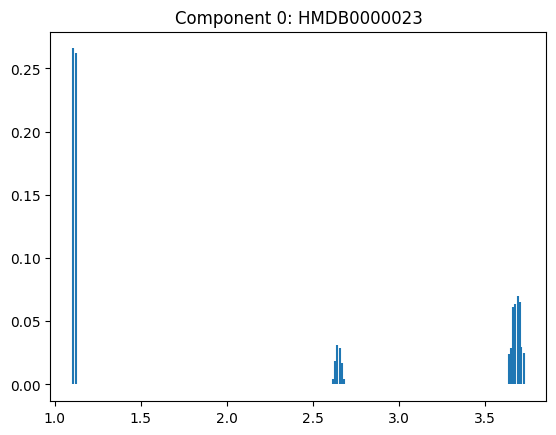

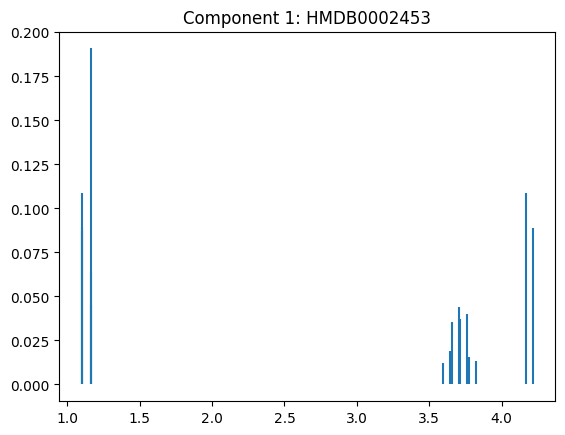

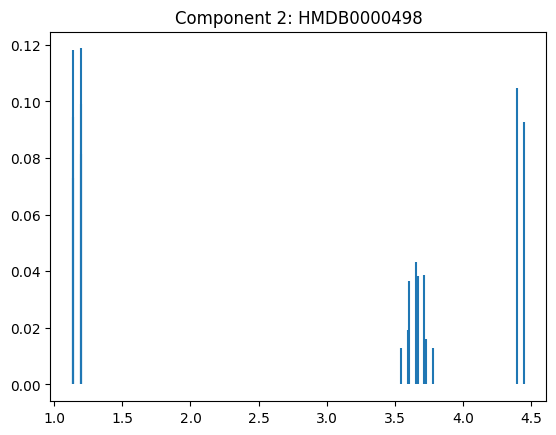

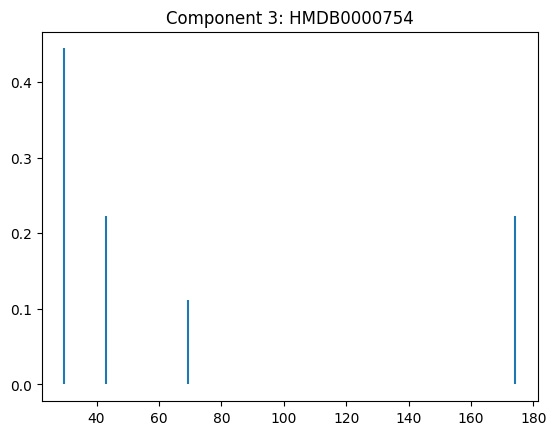

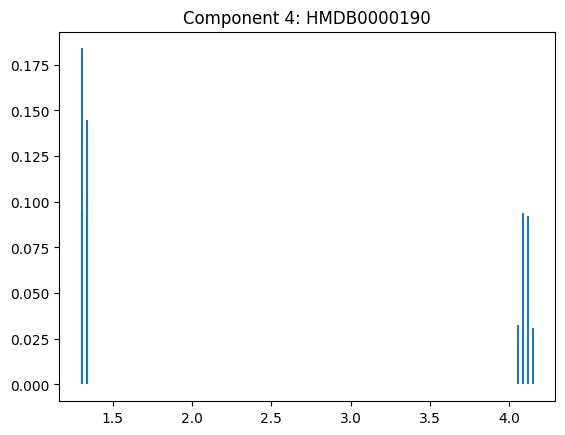

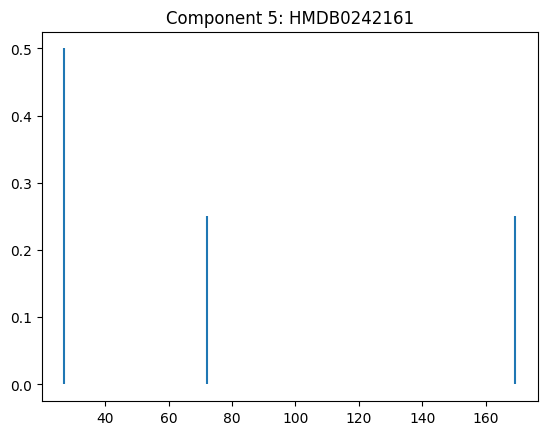

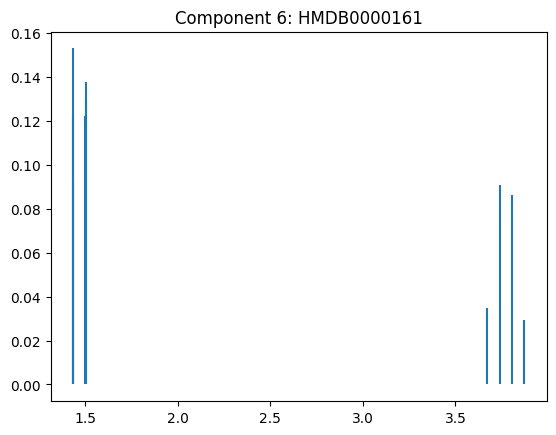

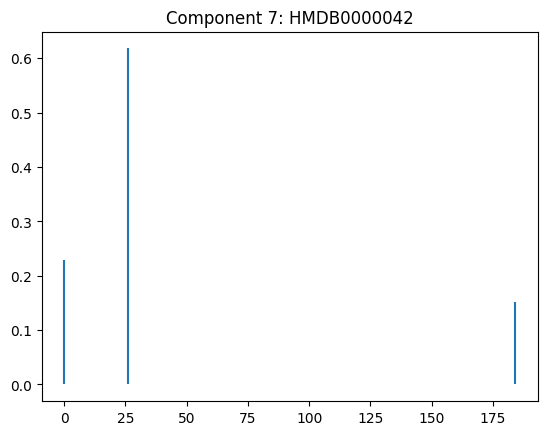

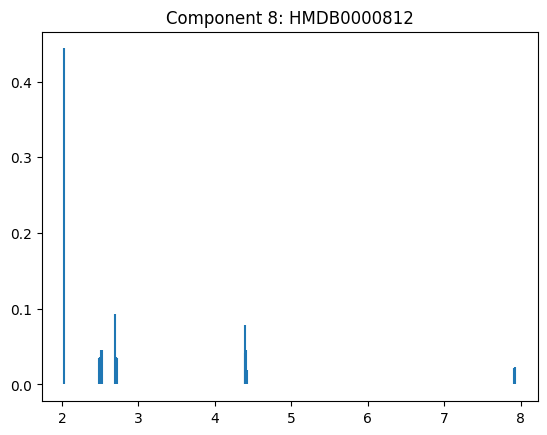

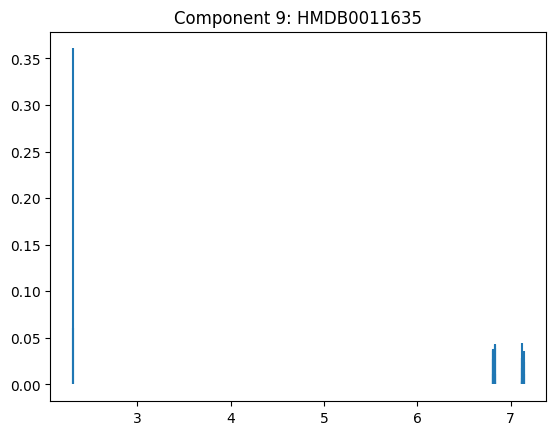

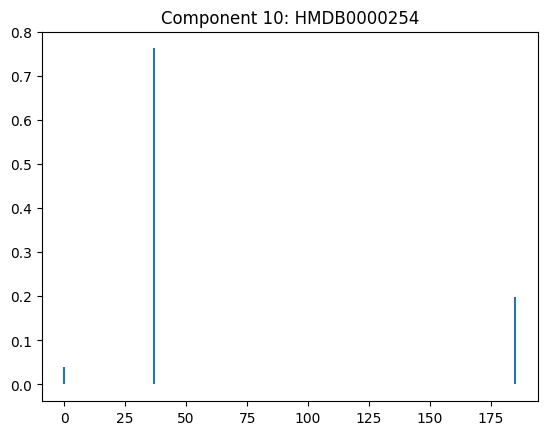

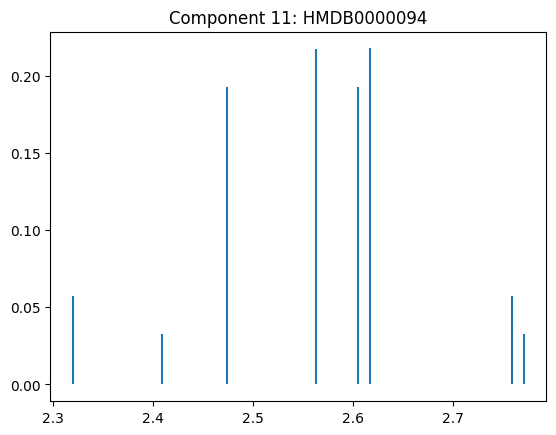

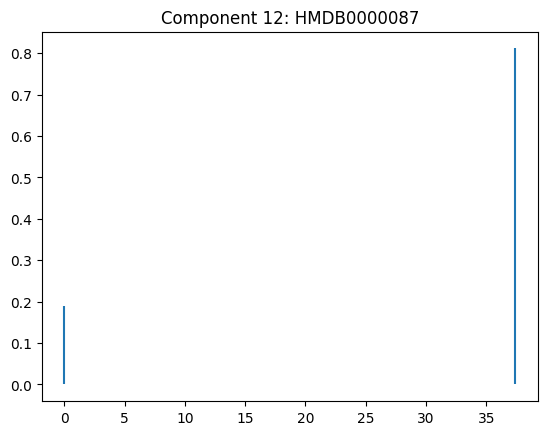

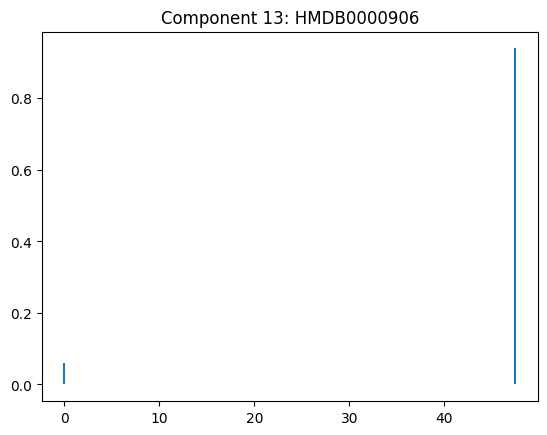

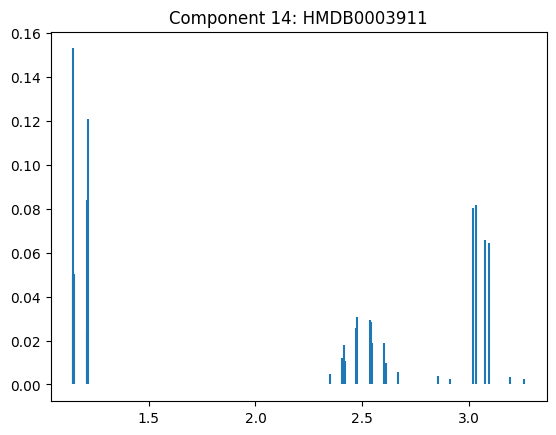

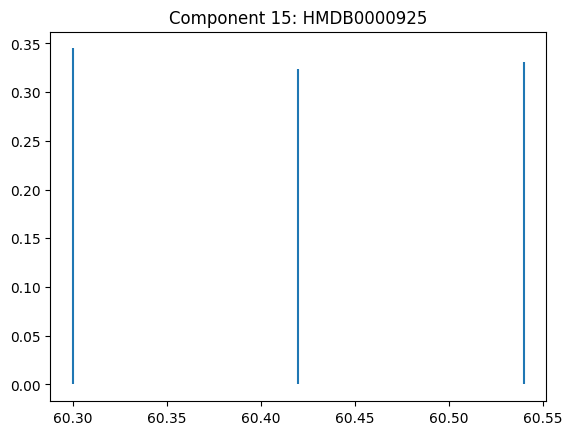

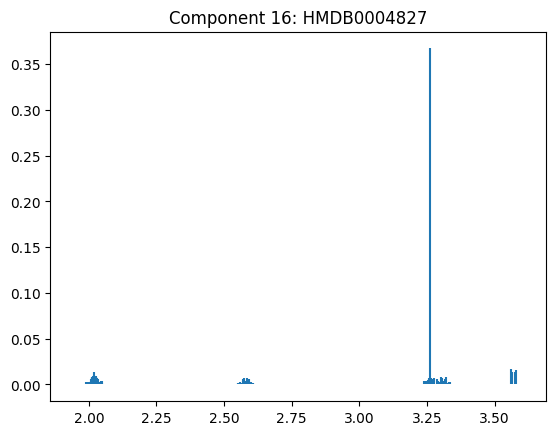

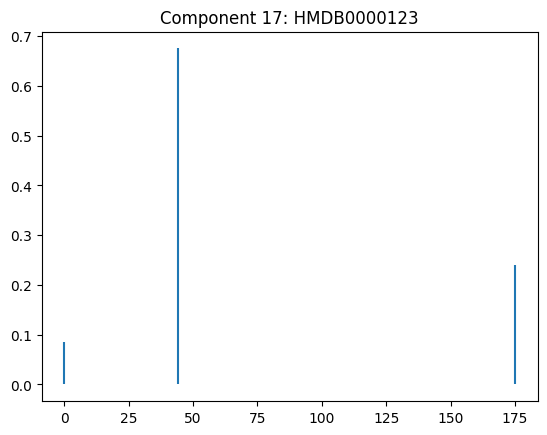

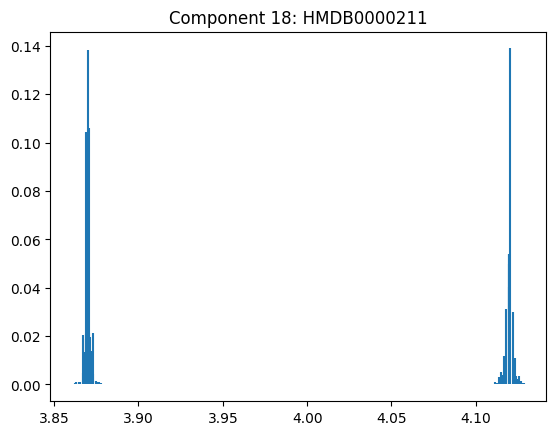

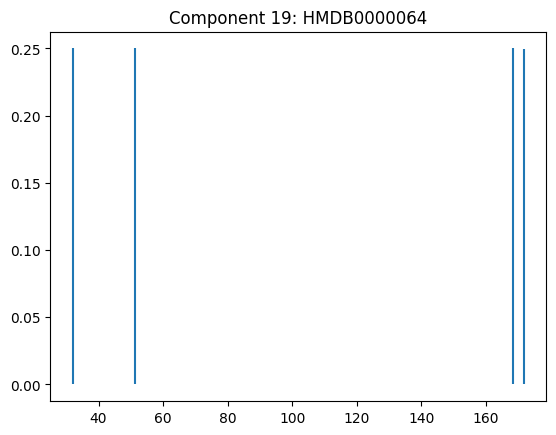

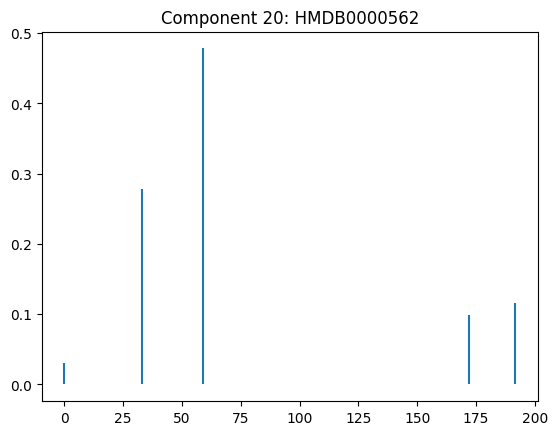

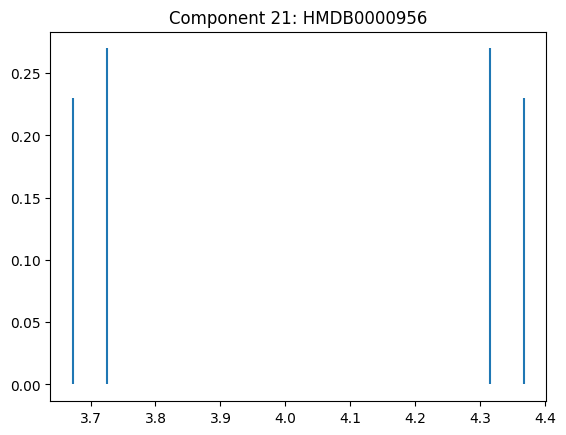

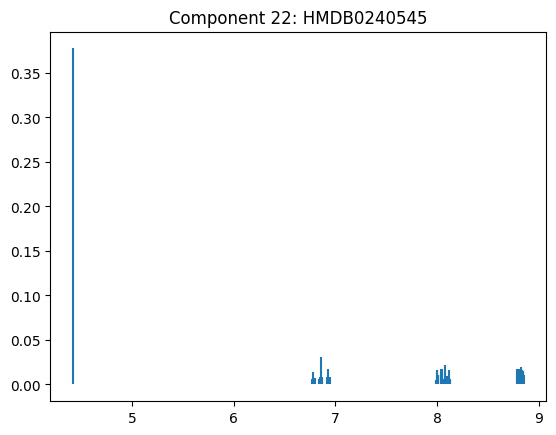

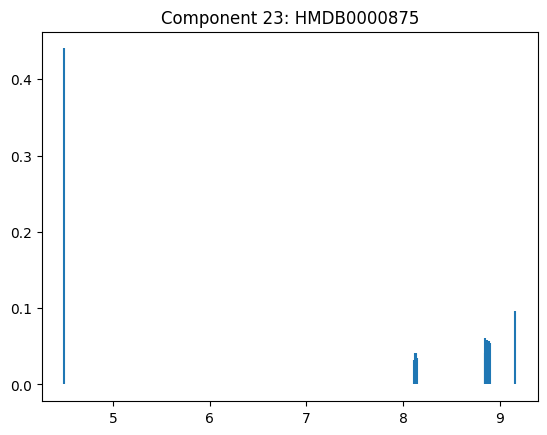

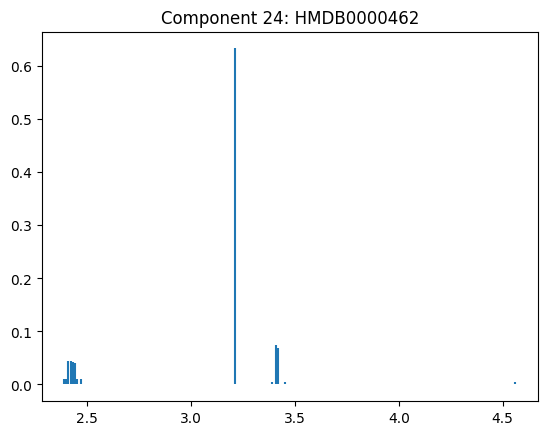

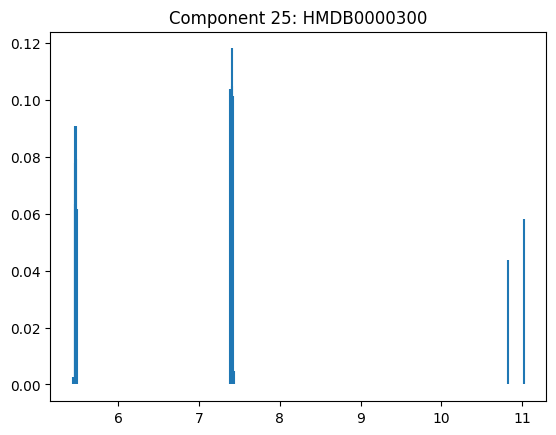

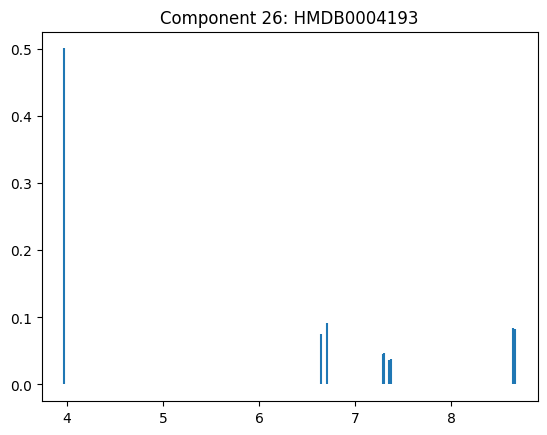

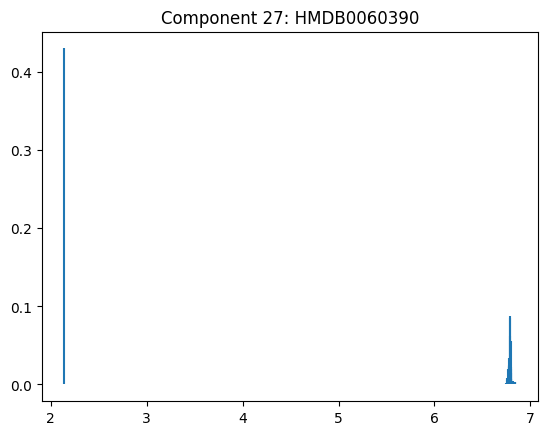

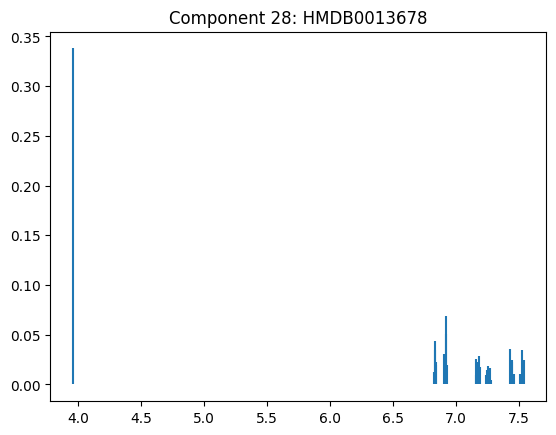

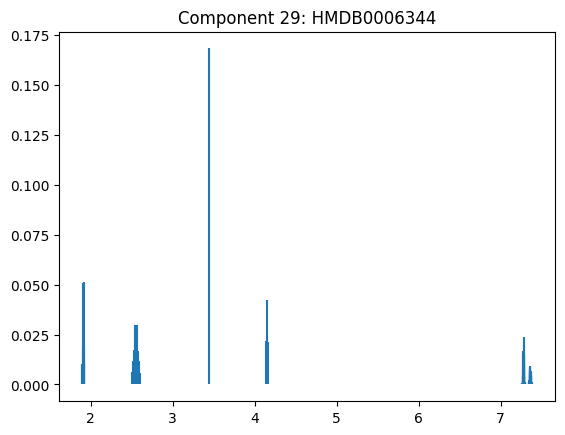

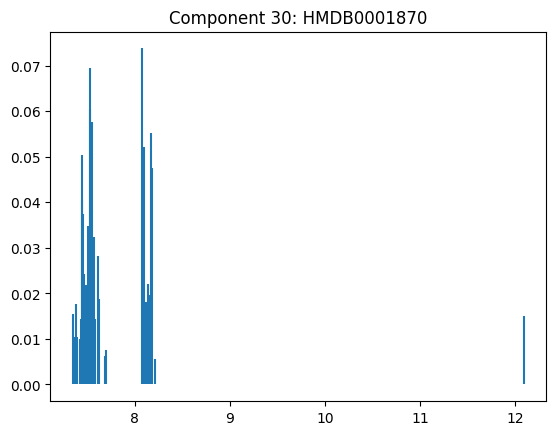

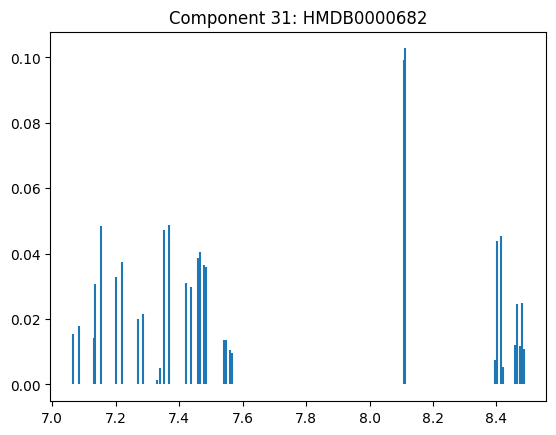

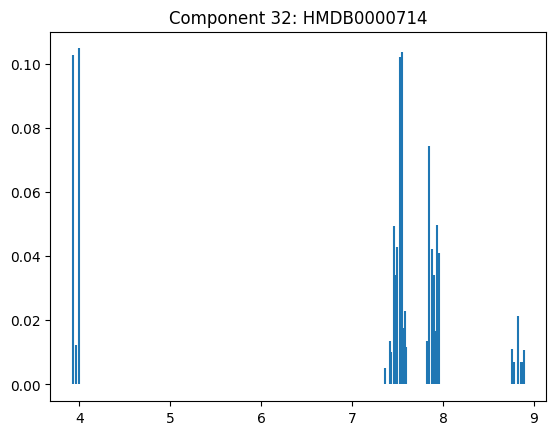

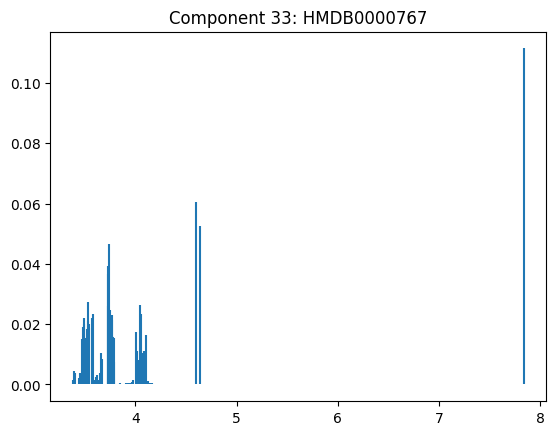

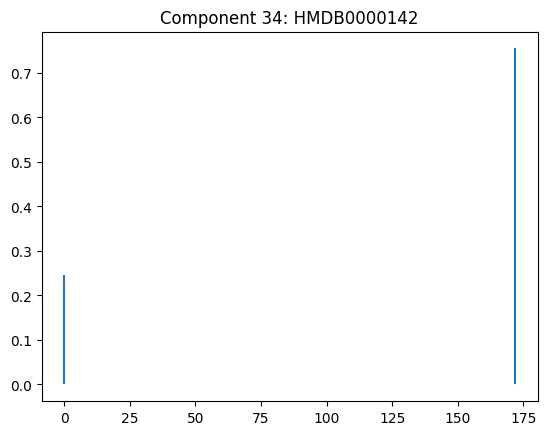

In [5]:
# rysowanie widm referencyjnych

os.makedirs('components_spectra', exist_ok=True)

for i, s in enumerate(spectra):
    plt.title(f'Component {i}: {s.label}')

    for conf in s.confs:
        plt.vlines(conf[0], 0, conf[1])
    
    plt.savefig(f'components_spectra/{s.label}.png')
    plt.show()


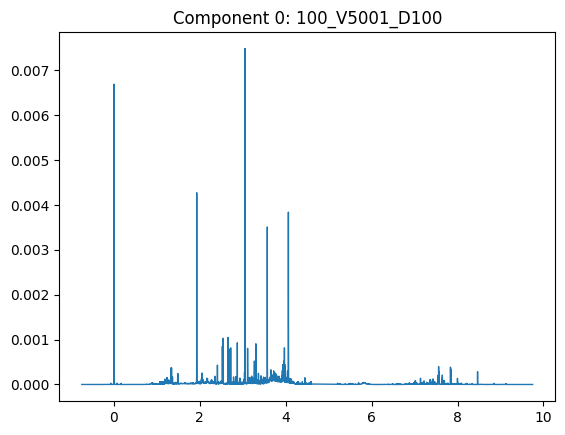

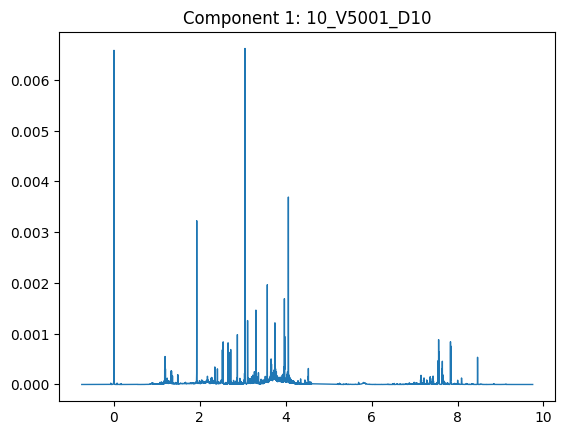

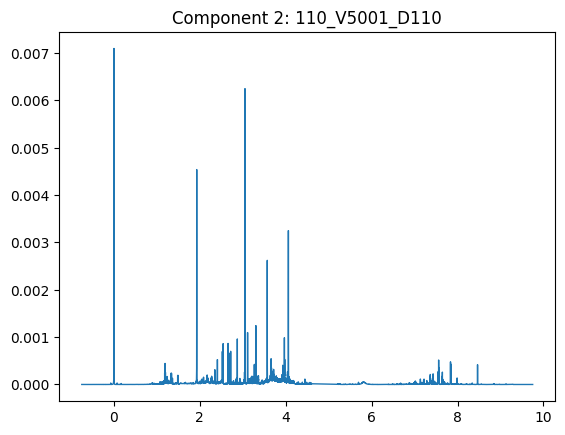

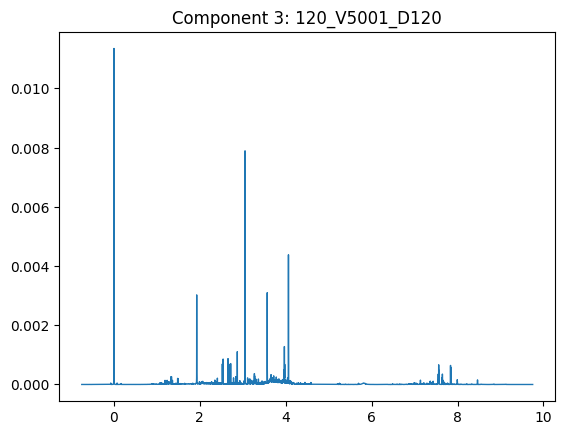

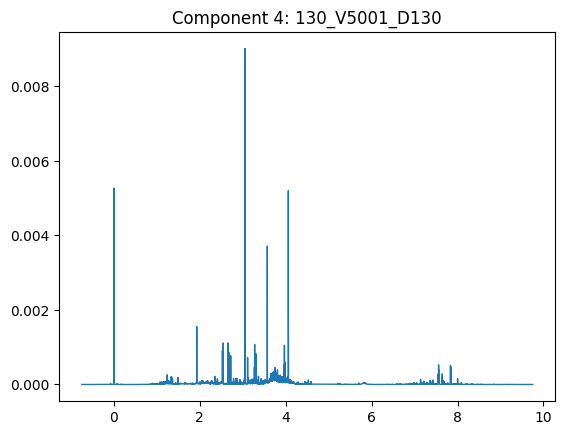

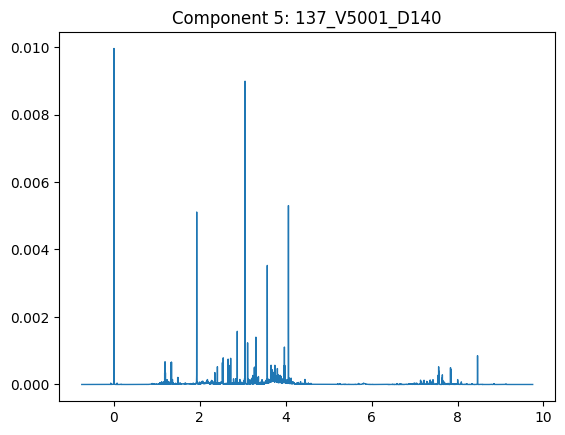

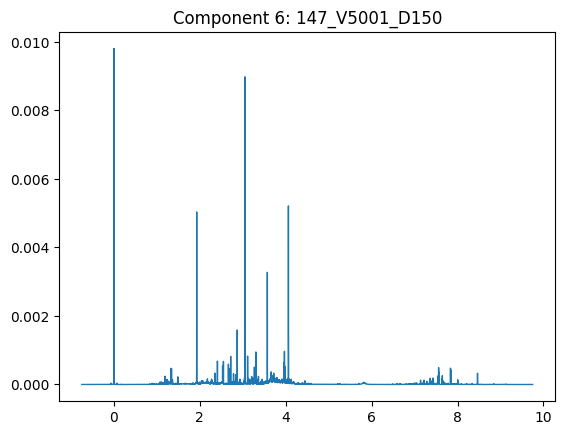

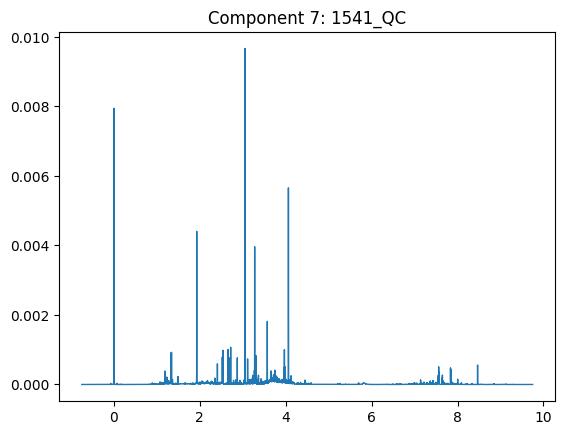

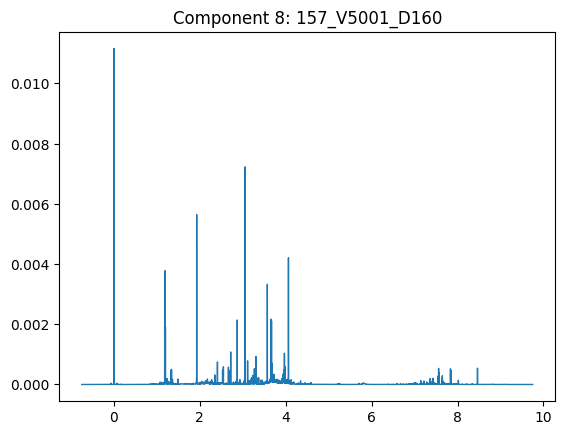

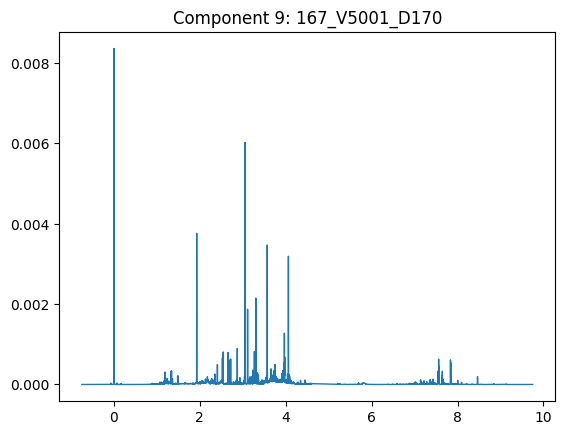

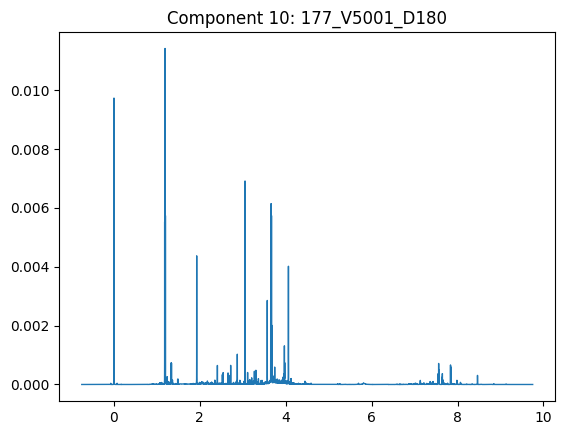

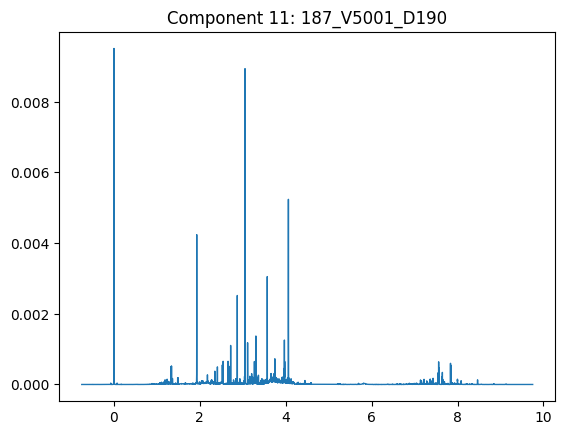

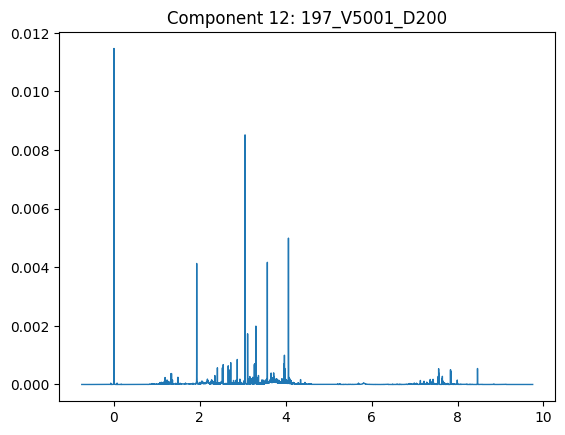

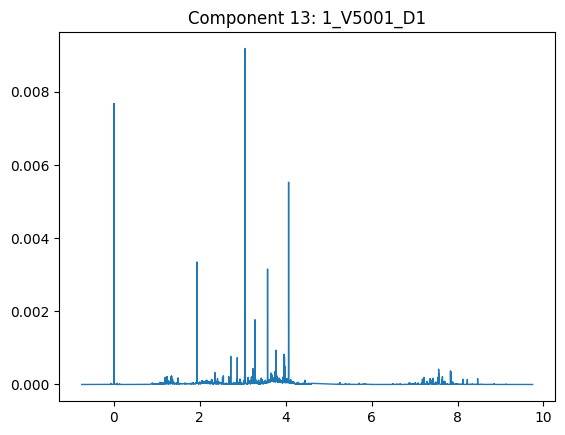

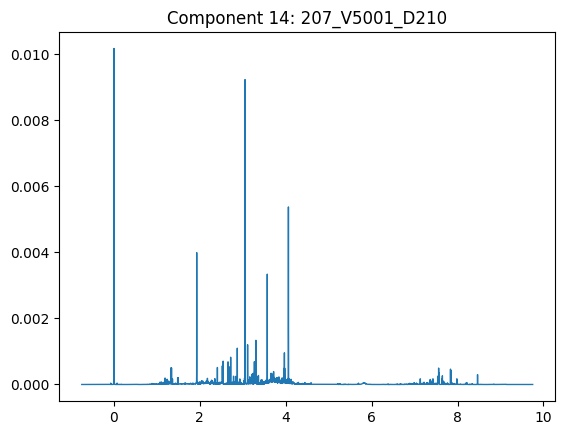

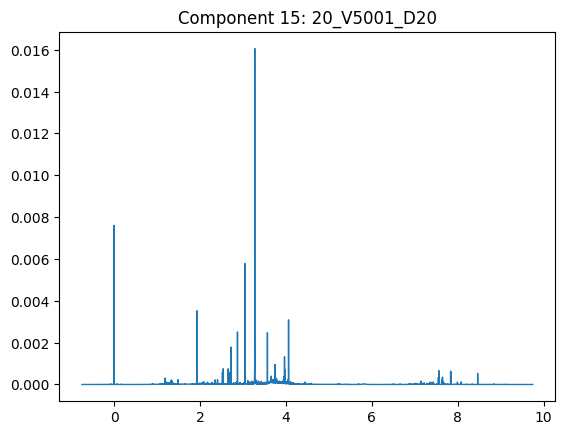

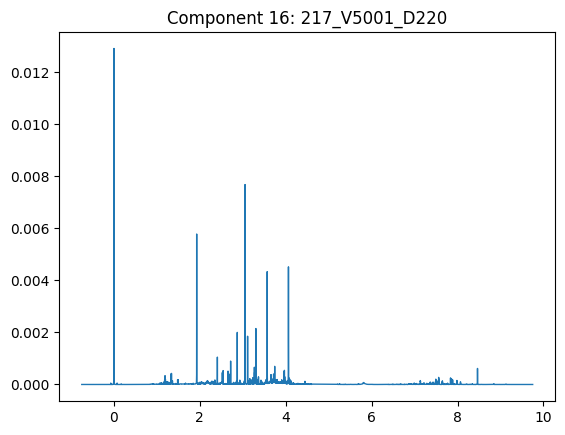

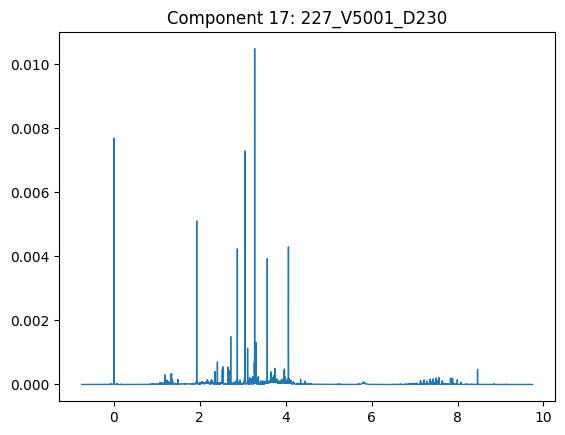

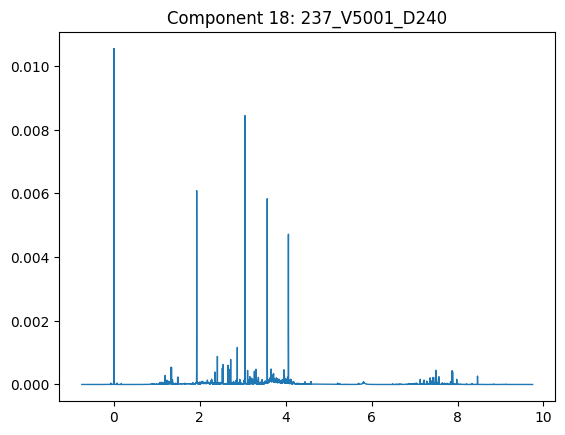

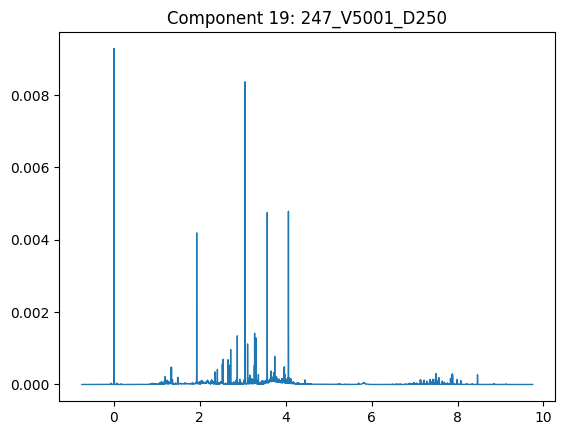

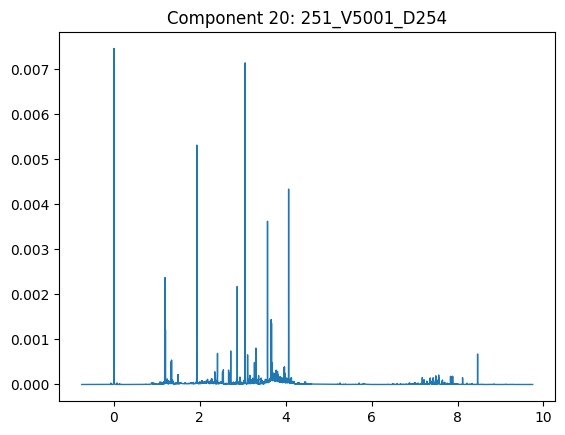

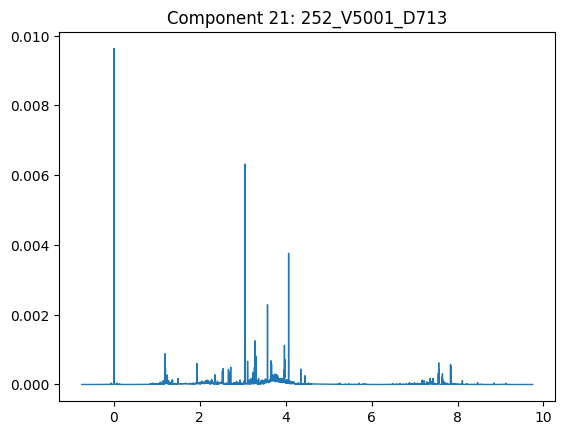

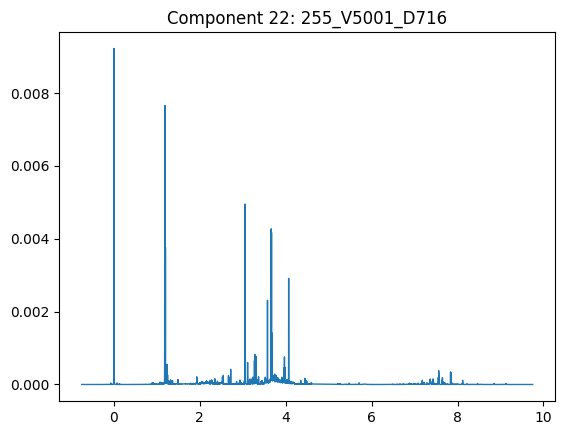

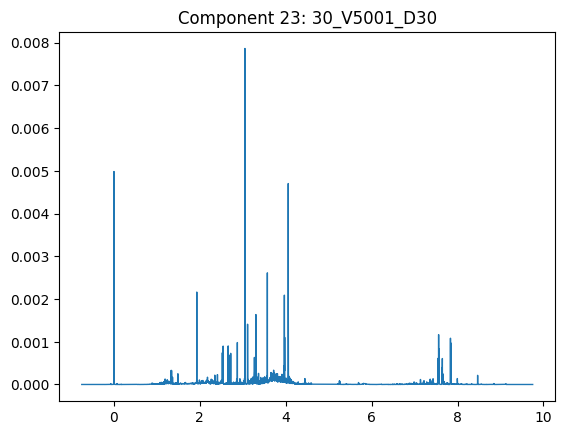

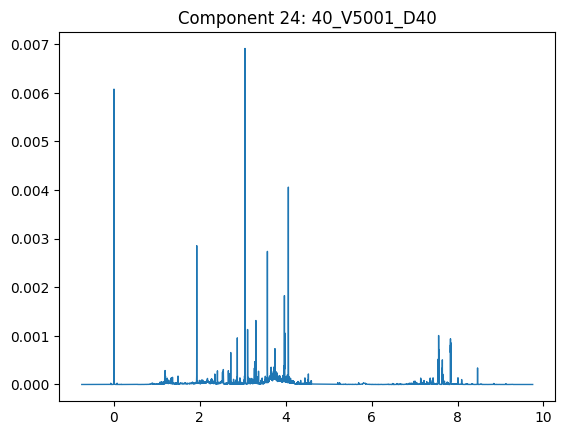

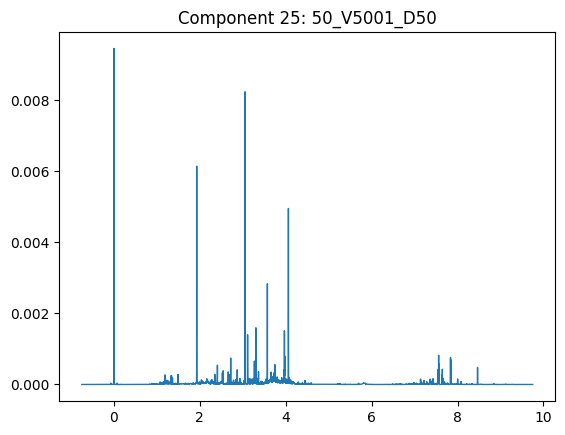

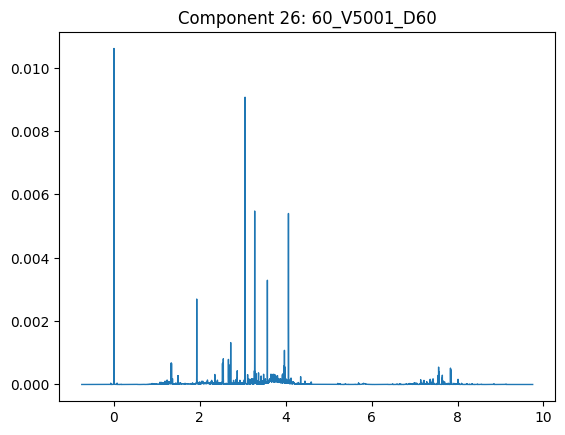

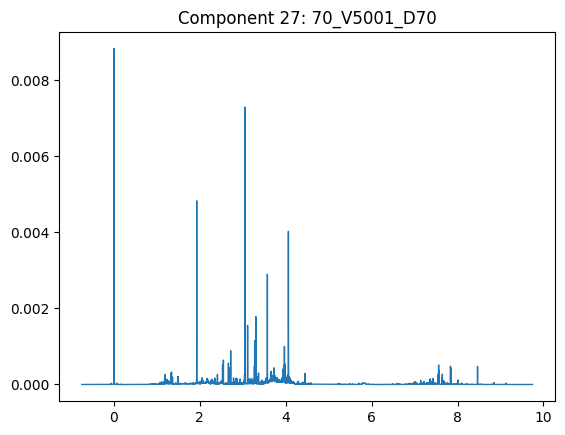

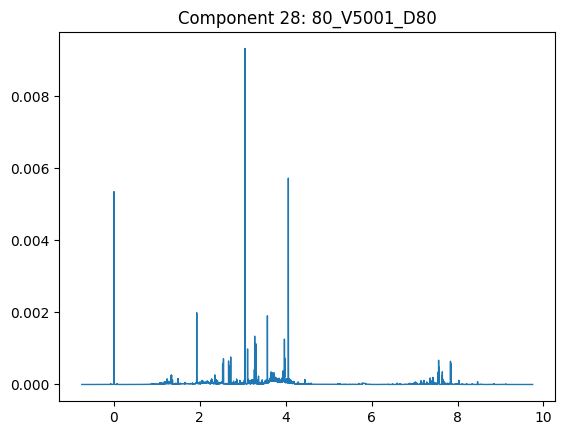

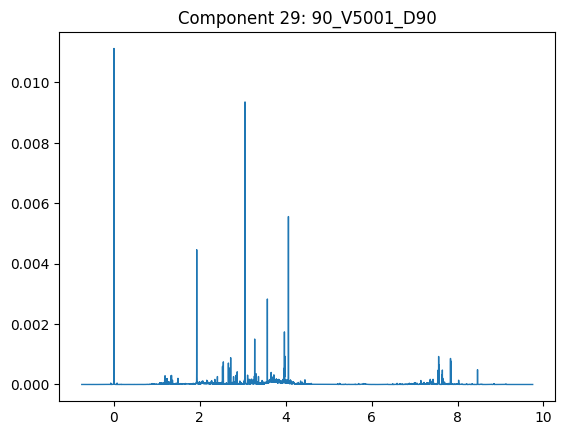

In [7]:
# rysowanie widm eksperymentalnych

os.makedirs('experimental_spectra', exist_ok=True)

for i, s in enumerate(experimental_spectra):
    plt.title(f'Component {i}: {s.label}')
    s.plot(profile=True, show=False)
    plt.savefig(f'experimental_spectra/{s.label}.png')
    plt.show()

In [5]:
# zadanie 2.1

def draw_estimation_result(experiment, references, proportions, min, max, save=False, filename=None):

    for ref, prop in zip(references, proportions):
        for conf in ref.confs:
            plt.vlines(conf[0], 0, conf[1] * prop, color='red') # mnożenie przez proporcje

    experiment.plot(profile=True, show=False)

    plt.plot([], [], color='red', label='Estimated Peaks')
    plt.xlim(min, max) # organiczenie osi x
    plt.xlabel('δ (ppm)')
    plt.ylabel('Intensity')
    plt.title(f'Experimental ({experiment.label}) vs Reference Spectra')
    plt.gca().invert_xaxis()  # typowe dla NMR
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    if save and filename:
        plt.savefig(f'{filename}/{experiment.label}.png')

    plt.show()
    

In [17]:
# przykładowe widma eksperymentalne do estymacji
mix1 = experimental_spectra[25] # dzień 50
mix2 = experimental_spectra[8] # dzień 160

QC = None # Quality Control sample

for ex in experimental_spectra:
    if 'QC' in ex.label:
        QC = ex

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

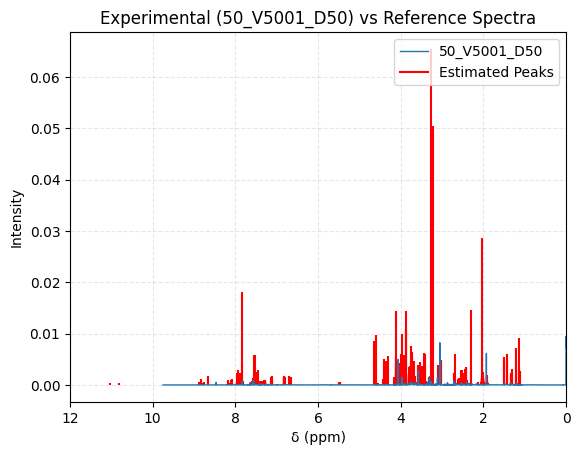

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

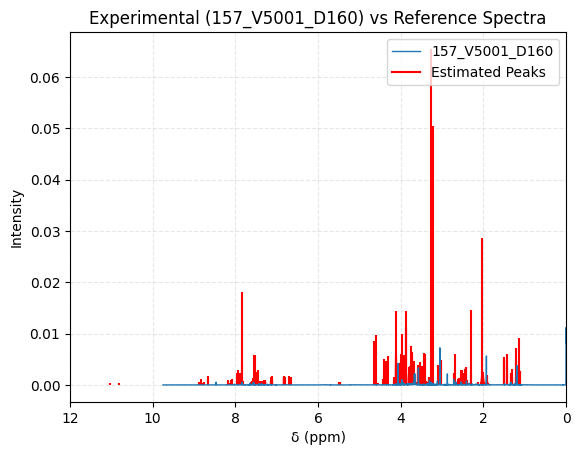

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

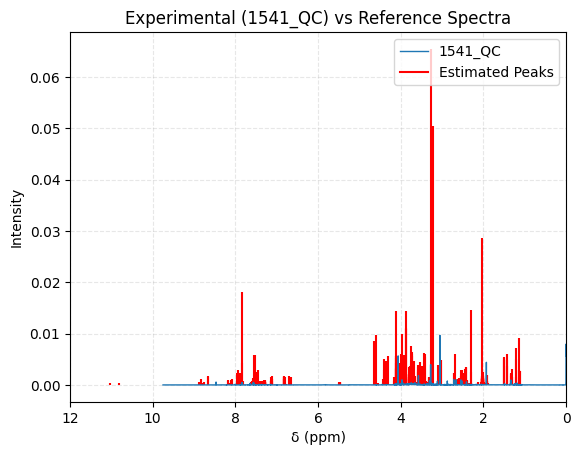

In [26]:
# zadanie 2.2 (GUROBI)

solver = pl.GUROBI(env=env, msg=False)

# domyślone wartości MTD i MTD_th
kappa_mixture = 0.25
kappa_components = 0.22

estimation_result_area_gurobi_mix1 = estimate_proportions(spectrum = mix1,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix1, spectra, estimation_result_area_gurobi_mix1['proportions'], 0, 12)

estimation_result_area_gurobi_mix2 = estimate_proportions(spectrum = mix2,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix2, spectra, estimation_result_area_gurobi_mix2['proportions'], 0, 12)

estimation_result_area_gurobi_QC = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_gurobi_QC['proportions'], 0, 12)

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

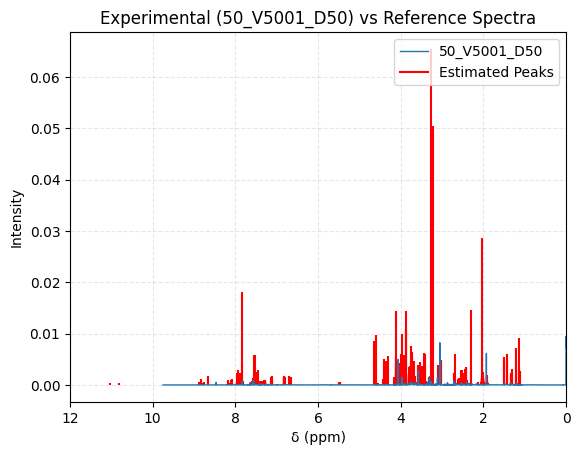

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

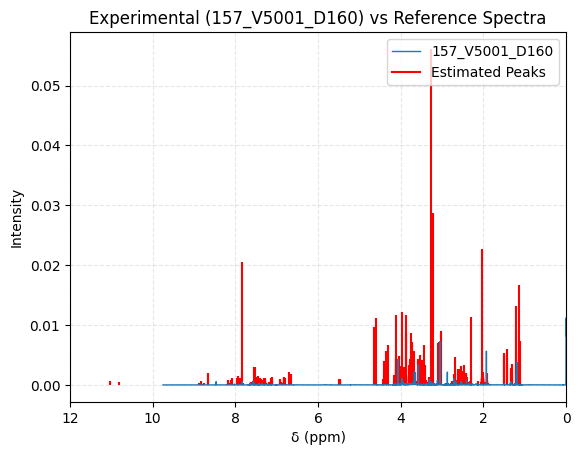

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

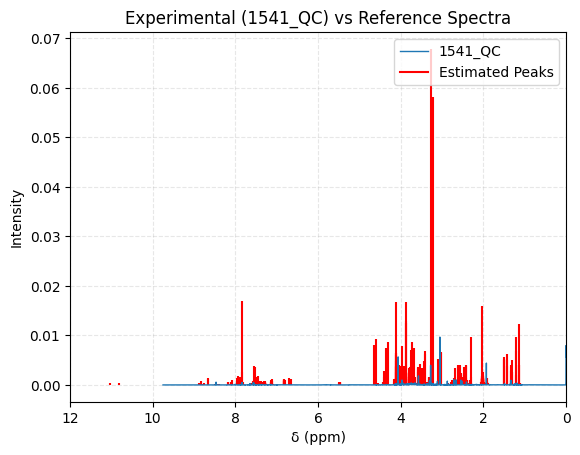

In [24]:
# zadanie 2.2 (MOSEK)

solver = pl.MOSEK(msg=False)

estimation_result_area_mosek_mix1 = estimate_proportions(spectrum = mix1,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix1, spectra, estimation_result_area_mosek_mix1['proportions'], 0, 12)


estimation_result_area_mosek_mix2 = estimate_proportions(spectrum = mix2,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix2, spectra, estimation_result_area_mosek_mix2['proportions'], 0, 12)


estimation_result_area_mosek_QC = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_mosek_QC['proportions'], 0, 12)

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

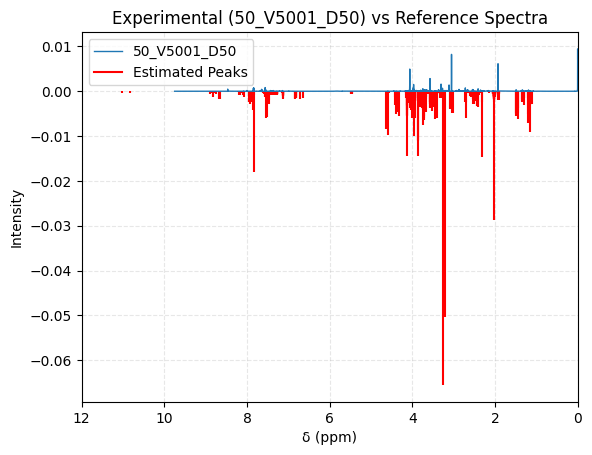

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

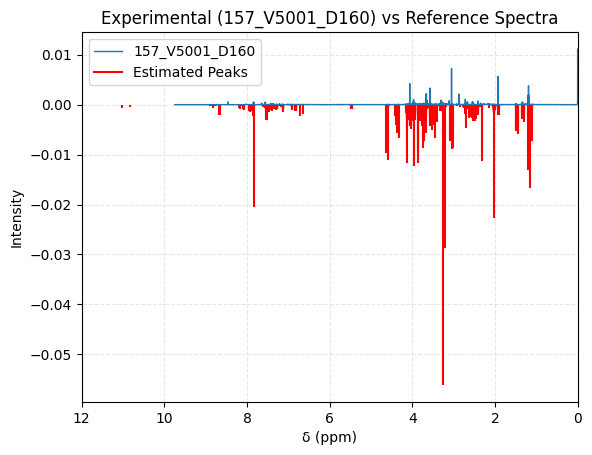

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

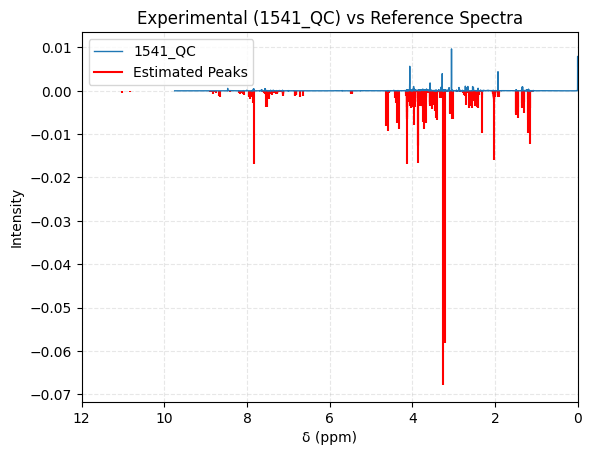

In [25]:
# zadanie 2.2 (HiGHs)

solver = pl.HiGHS(msg=False)

estimation_result_area_highs_mix1 = estimate_proportions(spectrum = mix1,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix1, spectra, estimation_result_area_highs_mix1['proportions'], 0, 12)


estimation_result_area_highs_mix2 = estimate_proportions(spectrum = mix2,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix2, spectra, estimation_result_area_highs_mix2['proportions'], 0, 12)


estimation_result_area_highs_QC = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_highs_QC['proportions'], 0, 12)

In [27]:
for i, s in enumerate(spectra):
    print(s.label, estimation_result_area_gurobi_mix1['proportions'][i], estimation_result_area_gurobi_mix2['proportions'][i], estimation_result_area_gurobi_QC['proportions'][i],
          estimation_result_area_mosek_mix1['proportions'][i], estimation_result_area_mosek_mix2['proportions'][i], estimation_result_area_mosek_QC['proportions'][i],
          estimation_result_area_highs_mix1['proportions'][i], estimation_result_area_highs_mix2['proportions'][i], estimation_result_area_highs_QC['proportions'][i])  

HMDB0000023 0.010498880031700885 0.010498341500333602 0.010497999703985426 0.010498880031700885 0.027696853401059283 0.0014676800373819028 -0.010498880031700885 -0.027696853401059283 -0.0014676800373819028
HMDB0002453 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
HMDB0000498 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
HMDB0000754 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
HMDB0000190 0.016399106402248908 0.016398265223650205 0.016397731342449092 0.016399106402248908 0.019373698933922743 0.027717158328356587 -0.0163991064032488 -0.019373698934922582 -0.027717158328356587
HMDB0242161 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
HMDB0000161 0.03978820655290931 0.03978616564976421 0.03978487032458103 0.03978820655290931 0.03900149018575418 0.040509009931200546 -0.03978820655490909 -0.03900149018675402 -0.04050900993220036
HMDB0000042 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0
HMDB0000812 0.064466624733788 0.0644633179715946 0.06446121922802893 0.064466624733788 0.05099623382191324 0.03594299019449214 -0.06446

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

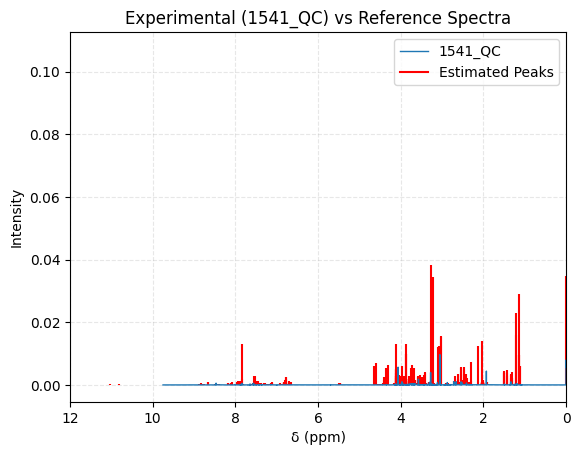

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

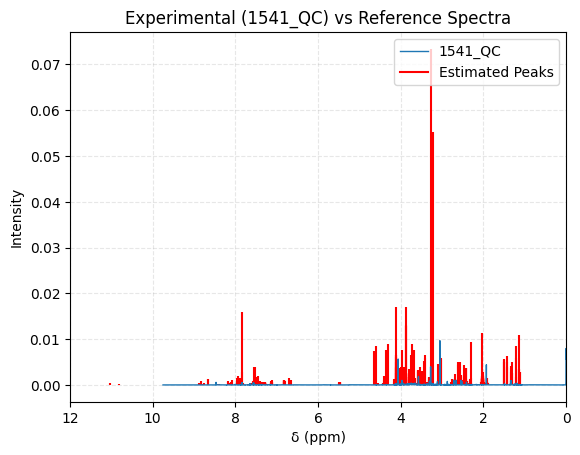

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

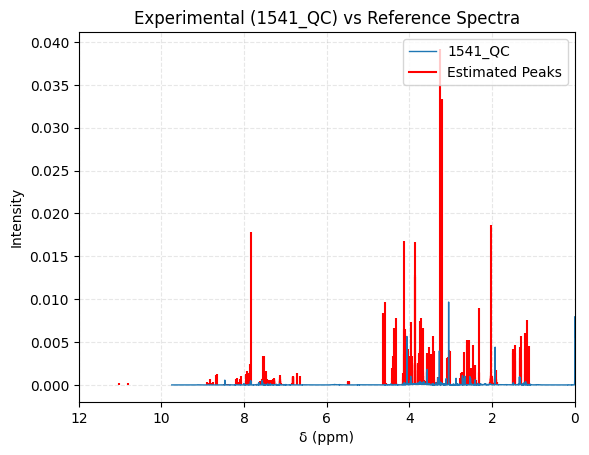

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

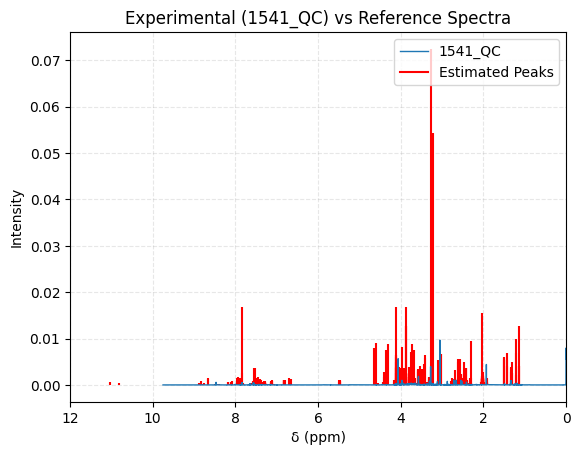

HMDB0000023 0.023123144165546203 0.010676807230359835 0.016929111690348213 0.0011490160687554762
HMDB0002453 -0.0 -0.0 -0.0 -0.0
HMDB0000498 -0.0 -0.0 -0.0 -0.0
HMDB0000754 0.0 0.0 0.0 0.0
HMDB0000190 0.023230495143784443 0.027809405112540264 0.03081253159625239 0.027373276492650592
HMDB0242161 0.0 0.0 0.0 0.0
HMDB0000161 0.03125988820689594 0.041305069312817896 0.030169462011879356 0.04436795644698025
HMDB0000042 -0.0 -0.0 -0.0 -0.0
HMDB0000812 0.03142693420315566 0.025408223879952528 0.042108832532526896 0.03509874363860238
HMDB0011635 0.020485661462586995 0.02577256704393245 0.024962446769862878 0.026314635714148063
HMDB0000254 -0.0 -0.0 -0.0 -0.0
HMDB0000094 -0.0 0.02297596418393633 0.024263506413298733 0.025464668838409223
HMDB0000087 -0.0 -0.0 -0.0 -0.0
HMDB0000906 -0.0 -0.0 -0.0 -0.0
HMDB0003911 0.18984890518575437 0.07072420531561131 0.049763030383034666 0.08270219817566685
HMDB0000925 0.0 0.0 0.0 0.0
HMDB0004827 0.10444039351429235 0.19998855086796763 0.10676937735937857 0.197

In [28]:
# zadanie 2.4

solver = pl.MOSEK(msg=False)

# zmianny parametrów kappa
kappa_mixture = 0.25
kappa_components = 0.15 # mniejsze kappa_components niż domyślne


estimation_result_area_mosek_25_15 = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_mosek_25_15['proportions'], 0, 12)


kappa_components = 0.3 # większe kappa_components niż domyślne

estimation_result_area_mosek_25_30 = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_mosek_25_30['proportions'], 0, 12)


kappa_mixture = 0.15 # mniejsze kappa_mixture niż domyślne
kappa_components = 0.22

estimation_result_area_mosek_15_22 = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_mosek_15_22['proportions'], 0, 12)



kappa_mixture = 0.3 # większe kappa_mixture niż domyślne

estimation_result_area_mosek_30_22 = estimate_proportions(spectrum = QC,
                                         query = spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, spectra, estimation_result_area_mosek_30_22['proportions'], 0, 12)

for i, s in enumerate(spectra):
    print(s.label, estimation_result_area_mosek_25_15['proportions'][i], estimation_result_area_mosek_25_30['proportions'][i], 
          estimation_result_area_mosek_15_22['proportions'][i], estimation_result_area_mosek_30_22['proportions'][i])


Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

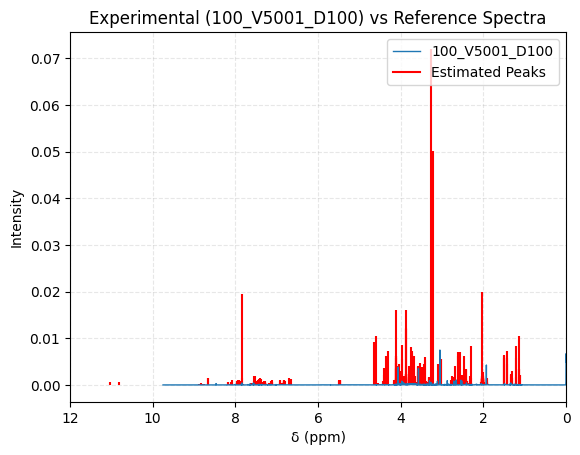

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

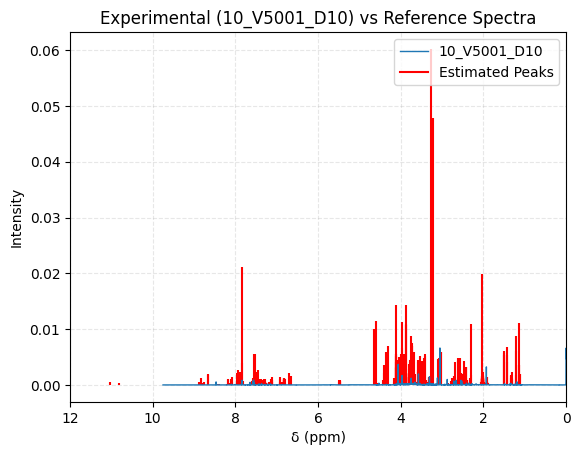

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

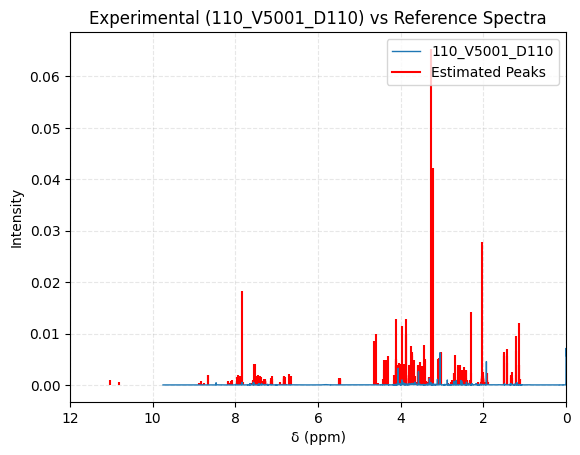

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

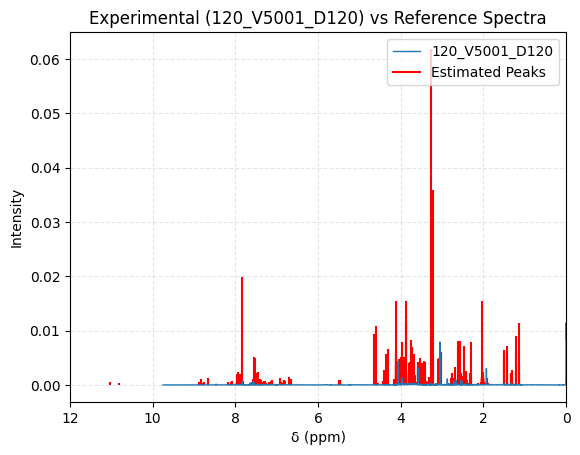

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

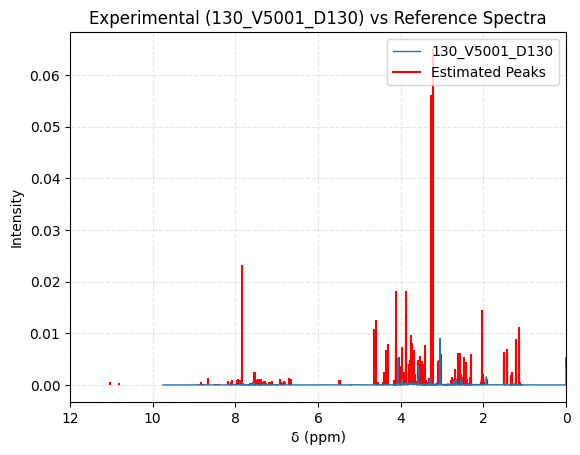

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

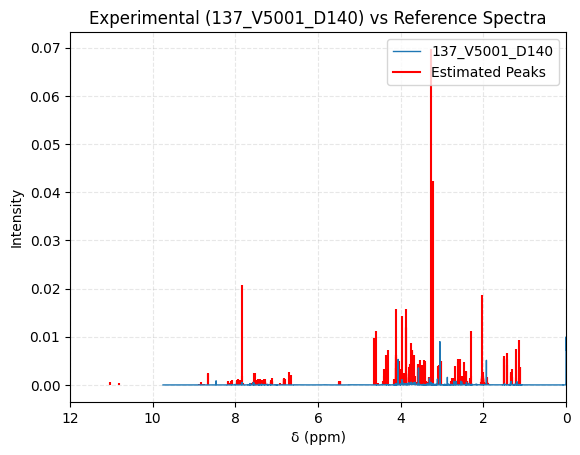

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

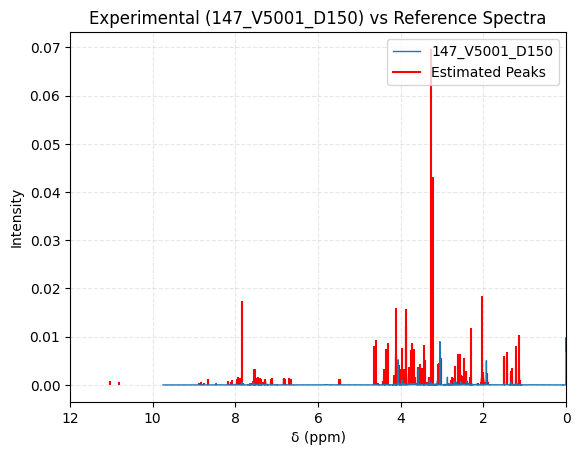

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

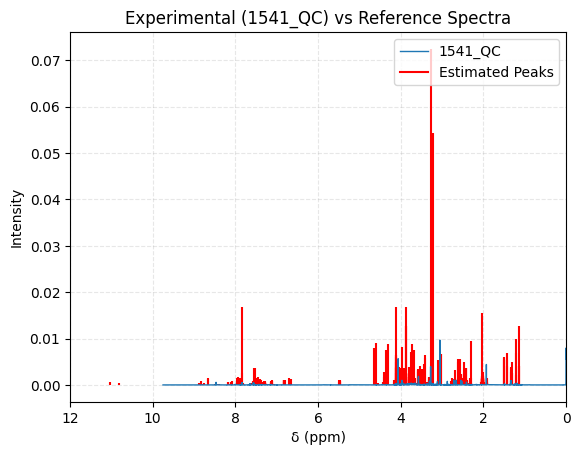

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

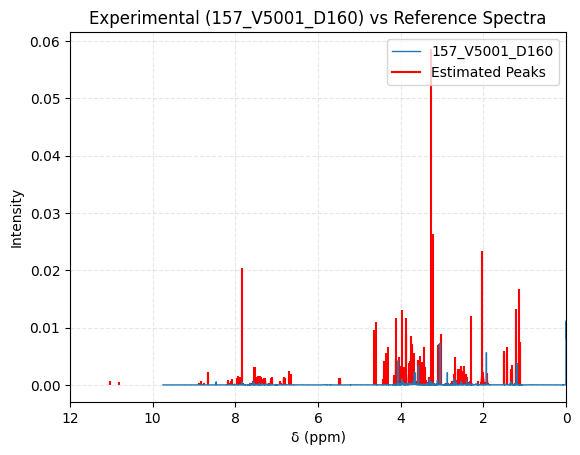

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

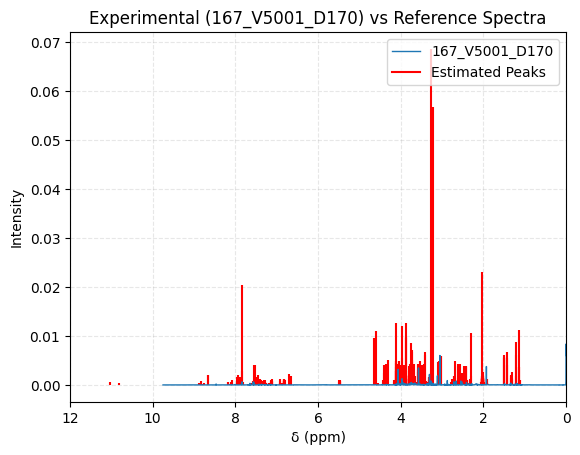

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

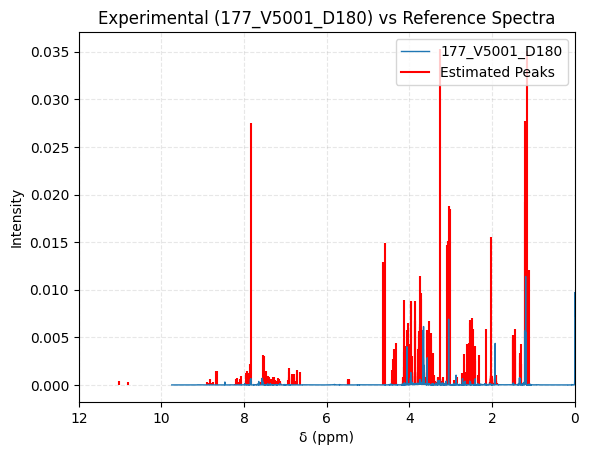

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

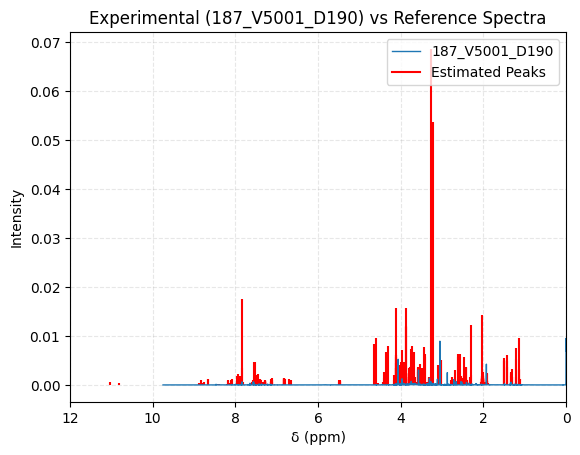

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

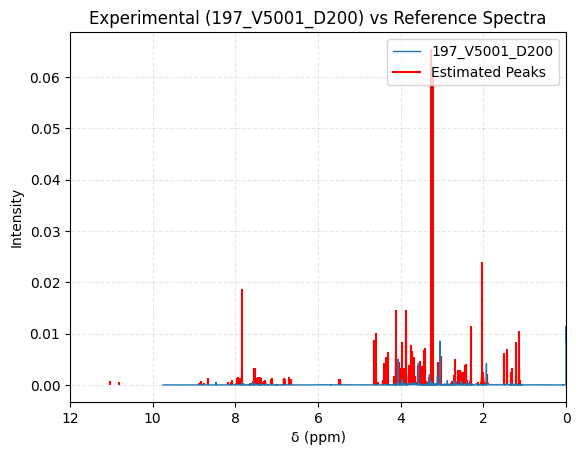

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

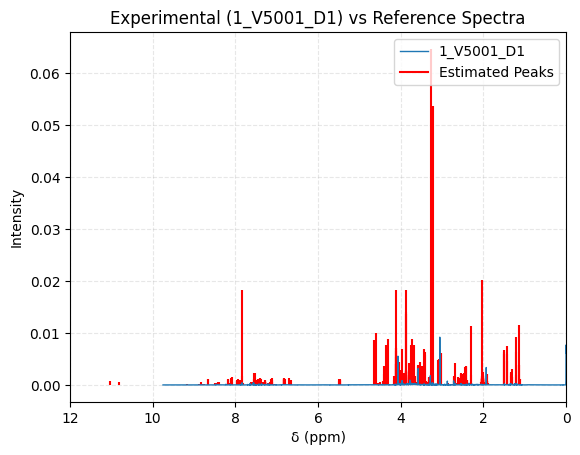

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

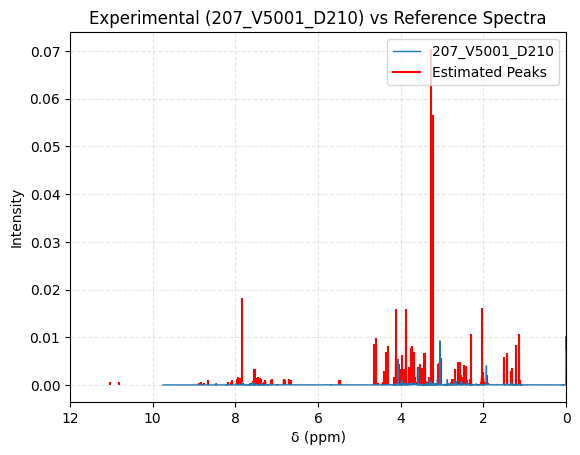

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

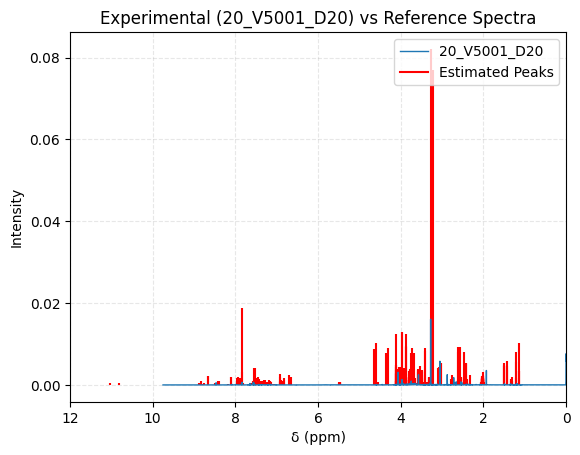

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

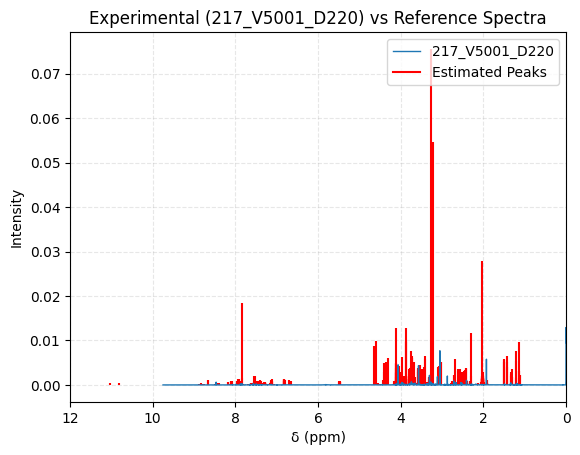

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

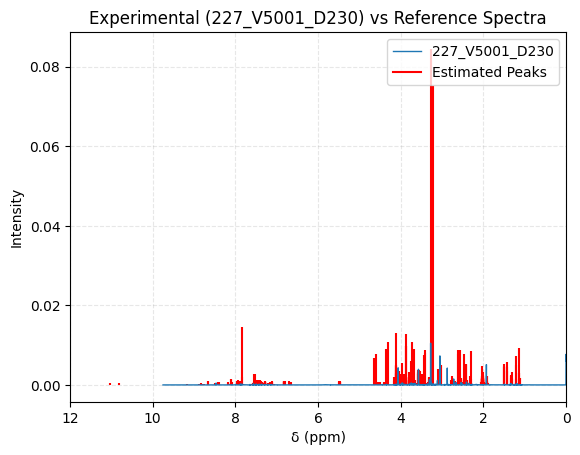

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

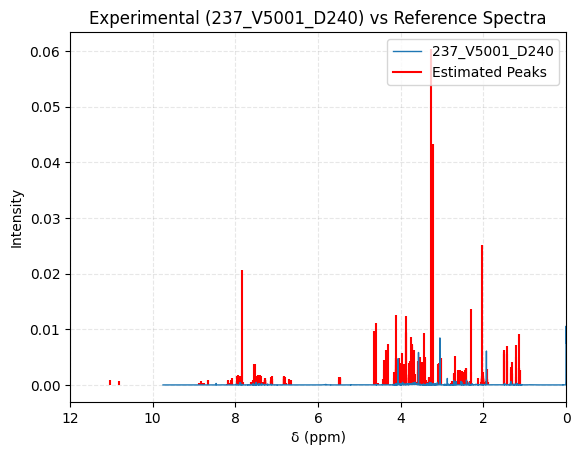

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

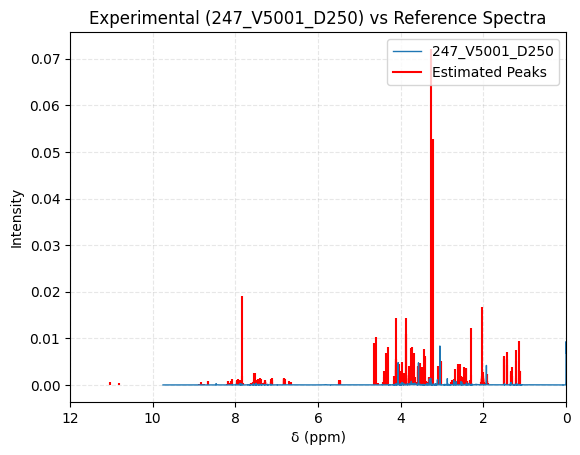

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

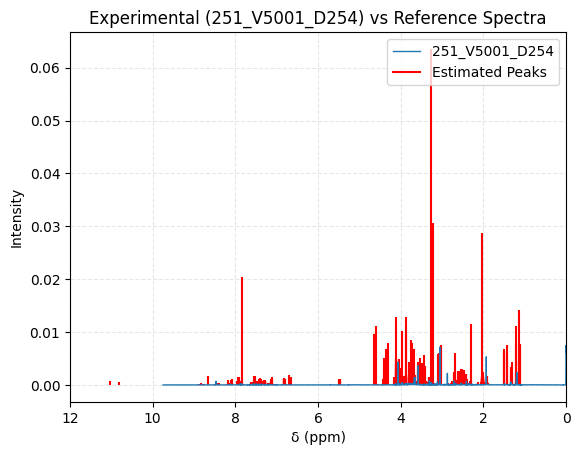

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

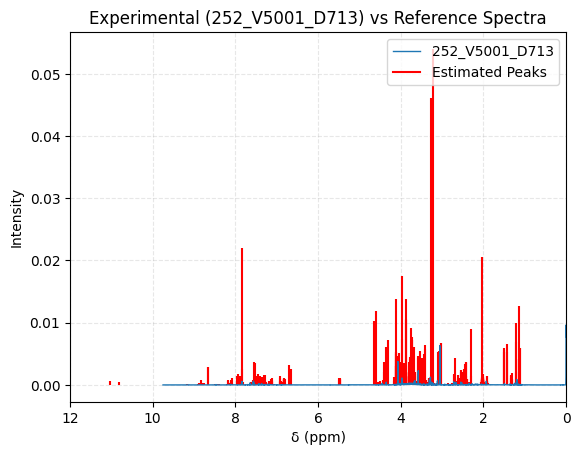

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

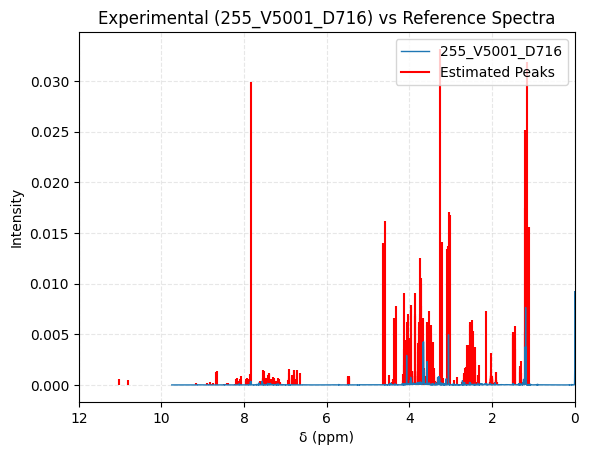

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

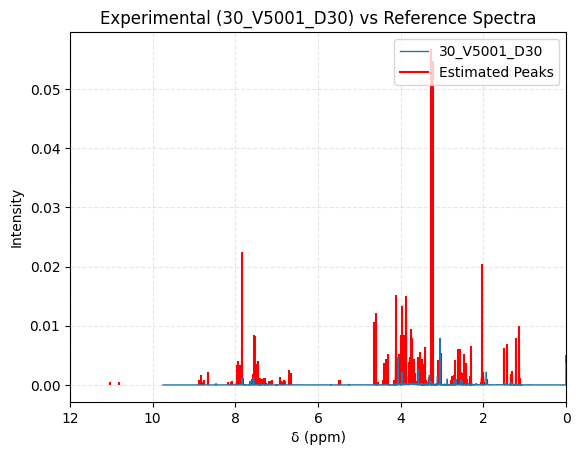

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

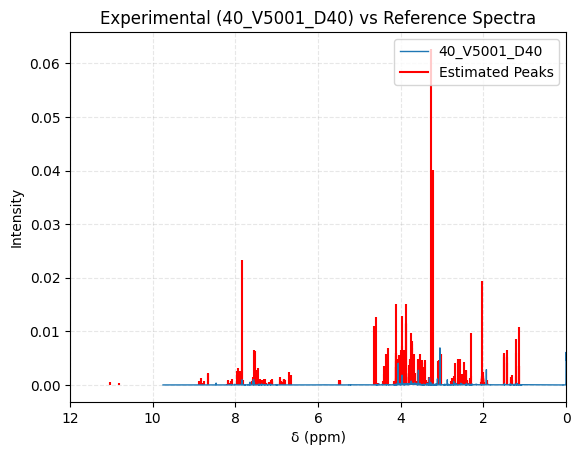

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

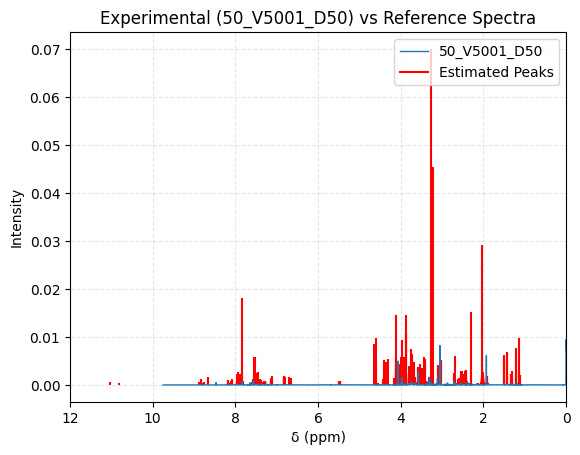

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

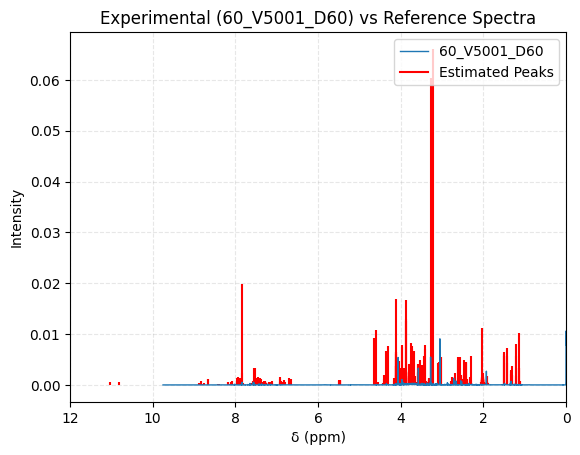

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

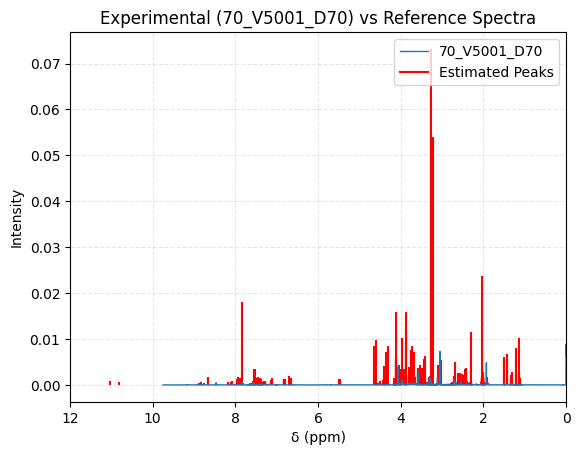

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

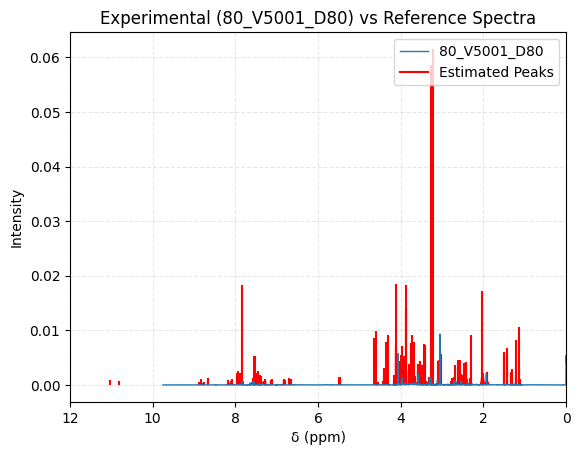

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 5, 15, 19]
Envelope bounds: [(-1, -1, 3), (-1, -1, 5), (-1, -1, 15), (-1, -1, 19), (-0.0038, 191.5967, 20), (-0.0023, 47.4597, 13), (-0.001, 171.8986, 34), (-0.0007, 184.9337, 10), (0.001, 37.4039, 12), (0.001, 175.1177, 17), (0.0018, 184.1082, 7), (1.098922729492188, 4.215255737304688, 1), (1.106, 3.727, 0), (1.138870239257813, 4.444793701171875, 2), (1.144638061523438, 3.25982666015625, 14), (1.304000854492188, 4.147430419921875, 4), (1.435592651367188, 3.870254516601563, 6), (1.893280029296875, 7.389747619628906, 29), (1.941452026367188, 3.608566284179688, 16), (2.03, 7.93, 8), (2.1400146484375, 6.842498779296875, 27), (2.310005187988281, 7.142745971679688, 9), (2.320419311523438, 2.77105712890625, 11), (2.39, 4.56, 24), (3.383193969726563, 7.840011596679688, 33), (3.673080444335938, 4.366928100585938, 21), (3.861175537109375, 4.128524780273438, 18), (3.931, 8.889, 32), (3.959976196289063, 7.539337158203

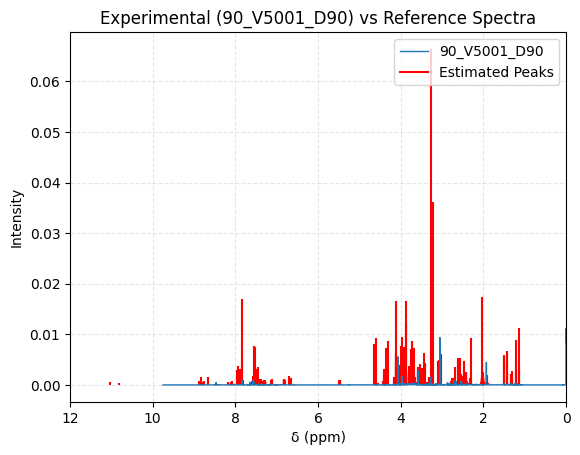

In [34]:
# zadanie 2.5

kappa_mixture = 0.3
kappa_components = 0.22

all_proportions = {}

os.makedirs('estimated_spectra', exist_ok=True)

for spec in experimental_spectra: # estymacja dla wszystkich widm eksperymentalnych
    estimation_result_area_mosek = estimate_proportions(spectrum=spec,
                                             query=spectra,
                                             MTD=kappa_mixture,
                                             MTD_th=kappa_components,
                                             solver=solver,
                                             verbose=True,
                                             what_to_compare='area',
                                             )

    draw_estimation_result(spec, spectra, estimation_result_area_mosek['proportions'], 0, 12, save=True, filename='estimated_spectra')
    all_proportions[spec.label] = estimation_result_area_mosek['proportions']

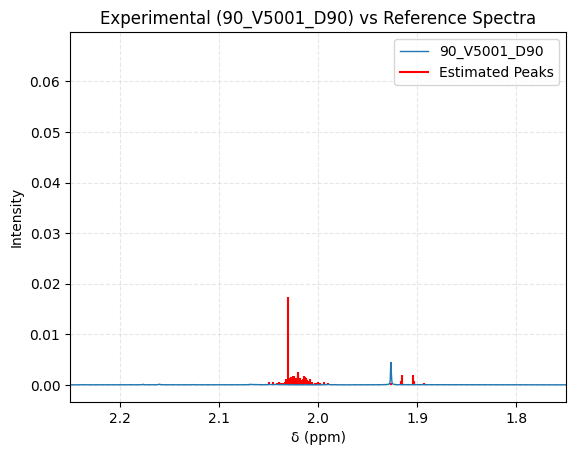

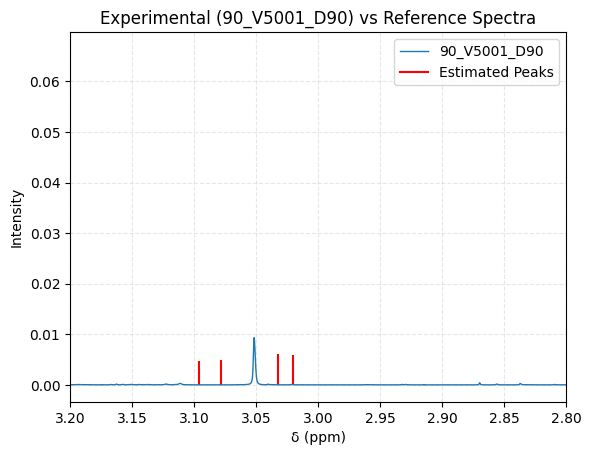

In [56]:
# kilka bardziej dokładnych wykresów na mniejszym zakresie

draw_estimation_result(experimental_spectra[-1], spectra, estimation_result_area_mosek['proportions'], 1.75, 2.25)

draw_estimation_result(experimental_spectra[-1], spectra, estimation_result_area_mosek['proportions'], 2.8, 3.2)

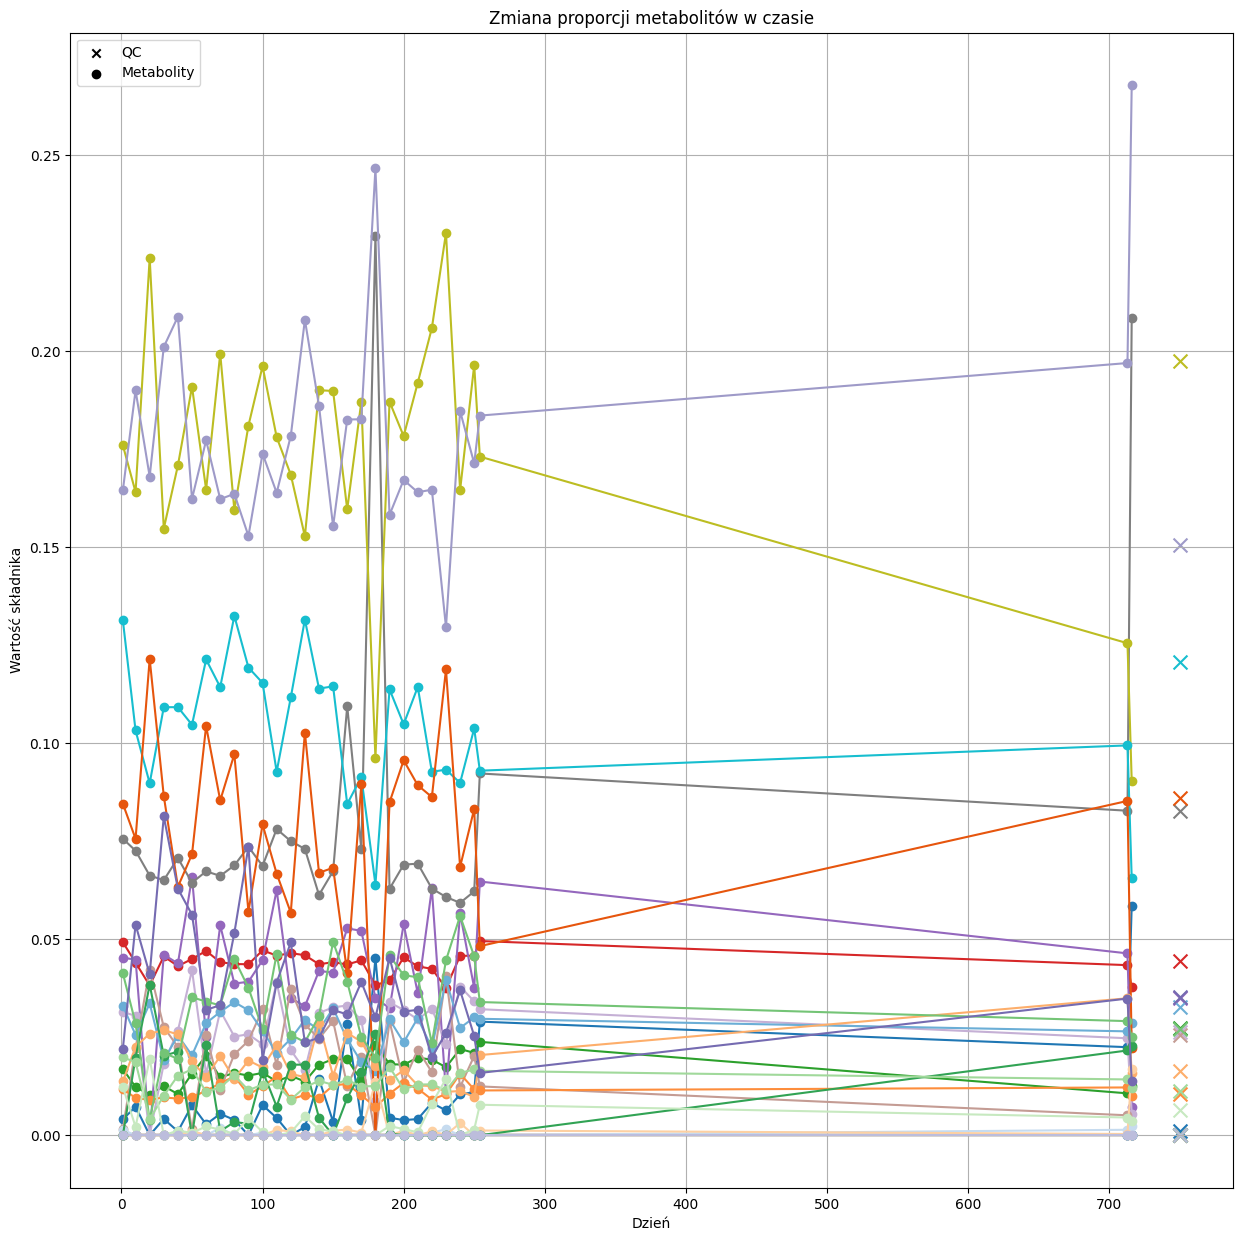

In [35]:
# zadanie 2.6

# oddzielenie próbek QC i próbek z różnych dni
QC_proportions = {k: v for k, v in all_proportions.items() if 'QC' in k}
sample_proportions = {k: v for k, v in all_proportions.items() if 'QC' not in k}

# posortowanie po dniach
sorted_items = sorted(sample_proportions.items(), key=lambda x: int(re.search(r"_D(\d+)", x[0]).group(1)))

days = [int(re.search(r"_D(\d+)", day).group(1)) for day, _ in sorted_items]
values = [v for _, v in sorted_items]

# zamiana, aby mieć dni jako kolumny
transposed = list(zip(*values))

qc_key = list(QC_proportions.keys())[0]
qc_values = QC_proportions[qc_key]

colors = plt.get_cmap('tab20').colors + plt.get_cmap('tab20c').colors
colors = colors[:35]

plt.figure(figsize=(15, 15))
for i, values_per_day in enumerate(transposed):

    # linia dla danych z poszczególnych dni
    plt.plot(days, values_per_day, marker='o', color=colors[i])
    
    # punkt QC dla poszczególnych metabolitów
    plt.scatter([750], [qc_values[i]], color=colors[i], marker='x', s=100)

# etykiety dla metabolitów i QC
plt.scatter([],[], marker='x', color='black', label='QC')
plt.scatter([],[], marker='o', color='black', label='Metabolity')

plt.xlabel("Dzień")
plt.ylabel("Wartość składnika")
plt.title("Zmiana proporcji metabolitów w czasie")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# zadanie 3.1

# wybór nowych referencyjnych metabolitów

# Wczytanie nowej biblioteki
df = pd.read_csv(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Data_urine\Data_urine\new_selected_metabolites.csv", sep='\t')

new_names = df["HMDB_id"].dropna().astype(str).unique()

files = os.listdir(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed")

# Słownik: metabolit : lista plików
new_grouped_files = defaultdict(list)

# Dla każdej wartości sprawdź, które pliki ją zawierają
for name in new_names:
    for file in files:
        if name in file:
            new_grouped_files[name].append(file)

new_chosen_reference = []

for name in new_grouped_files:
    #print(f"hmdb id: {name}")
    current_best = [0, '']


    for file in new_grouped_files[name]:

        df = pd.read_csv(os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed", file))
        if not ((df['intensity'] == 0).all()): # sprawdzenie, czy nie ma tylko zerowych intensywności
            no_peaks = df.shape[0]
            print(f"  - {file}", 'liczba pików: ', no_peaks)

            # wybór danych z największa liczbą pików
            if 'experimental' in file: # preferencja na dane eksperymentalne
                if no_peaks >= current_best[0]:
                    current_best[0] = no_peaks
                    current_best[1] = file
            
            elif no_peaks > current_best[0]:
                    current_best[0] = no_peaks
                    current_best[1] = file


    new_chosen_reference.append(current_best[1])

    print()  # pusty wiersz między grupami

print("Wybrane referencyjne wartości dla każdego HMDB ID:")
for ref in new_chosen_reference:
    print(ref)

  - HMDB0000042_1D_1048_experimental_1H_500_processed.csv liczba pików:  1
  - HMDB0000042_1D_1126_experimental_1H_125_processed.csv liczba pików:  3
  - HMDB0000042_1D_2560_experimental_1H_90_processed.csv liczba pików:  2
  - HMDB0000042_1D_3258_experimental_1H_25_processed.csv liczba pików:  2
  - HMDB0000042_1D_4746_experimental_1H_unknown_processed.csv liczba pików:  1
  - HMDB0000042_1D_5432_predicted_1H_100_processed.csv liczba pików:  1
  - HMDB0000042_1D_5433_predicted_1H_100_processed.csv liczba pików:  2
  - HMDB0000042_1D_5434_predicted_1H_200_processed.csv liczba pików:  2
  - HMDB0000042_1D_5435_predicted_1H_200_processed.csv liczba pików:  2
  - HMDB0000042_1D_5436_predicted_1H_300_processed.csv liczba pików:  2
  - HMDB0000042_1D_5437_predicted_1H_300_processed.csv liczba pików:  2
  - HMDB0000042_1D_5438_predicted_1H_400_processed.csv liczba pików:  3
  - HMDB0000042_1D_5439_predicted_1H_400_processed.csv liczba pików:  2
  - HMDB0000042_1D_5440_predicted_1H_500_proces

In [53]:
# tworzenie obiektów NMRSpectrum dla nowych widm referencyjnych

new_names = []
for ref in new_chosen_reference:
    new_names.append(ref.split('_')[0])


new_spectra = []
for name, path in zip(new_names, new_chosen_reference):

    confs = np.loadtxt(os.path.join(r"C:\Users\agnie\Desktop\biolsys\Projekt 4\Preprocessed", path), delimiter=',' , skiprows=1)
    spectrum = NMRSpectrum(confs=list(zip(confs[:,0], confs[:,1])), label=name)
    
    spectrum.trim_negative_intensities()
    spectrum.normalize()
    new_spectra.append(spectrum)

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 22, 27, 29, 52]
Envelope bounds: [(-1, -1, 3), (-1, -1, 22), (-1, -1, 27), (-1, -1, 29), (-1, -1, 52), (-0.0038, 191.5967, 4), (-0.0023, 47.4597, 14), (-0.001, 171.8986, 6), (-0.0001, 218.0914, 19), (0.0, 172.9516, 24), (0.0, 165.4828, 51), (0.001, 37.4039, 5), (0.001, 175.1177, 7), (0.0018, 184.1082, 0), (0.0027, 212.85, 18), (0.0857, 177.6724, 28), (0.9163818359375, 2.781097412109375, 45), (1.099136352539063, 5.327911376953125, 34), (1.144638061523438, 3.25982666015625, 17), (1.163, 11.882, 30), (1.280075073242188, 3.802215576171875, 37), (1.304000854492188, 4.147430419921875, 10), (1.304641723632813, 4.298995971679688, 39), (1.435592651367188, 3.870254516601563, 1), (1.504913330078125, 2.4544677734375, 20), (1.524246215820313, 3.870040893554688, 21), (1.563125610351563, 4.246124267578125, 46), (1.736053466796875, 4.312240600585938, 48), (1.893280029296875, 7.389747619628906, 12), (1.99774169921875, 3.821

c:\Users\agnie\AppData\Local\Programs\Python\Python312\Lib\site-packages\pulp\pulp.py:1455: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Chunk %i deconvolution status: Optimal
Signal proportion in mixture's spectrum: 0.988638212977
Noise proportion in mixture's spectrum: 0.01136178708
Total explanation: 1.000000000057
Noise proportion in combination of components' spectra: 0.049219057454


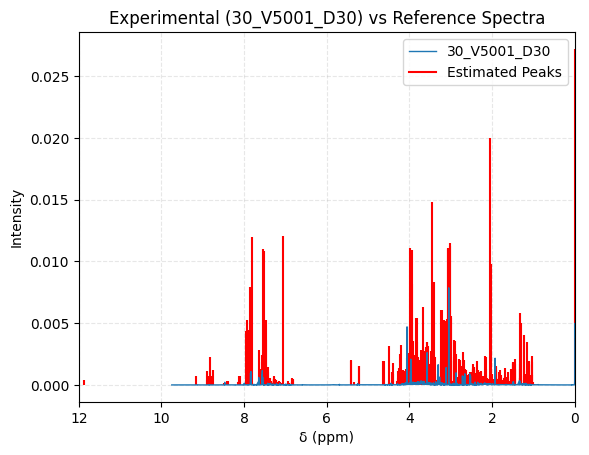

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 22, 27, 29, 52]
Envelope bounds: [(-1, -1, 3), (-1, -1, 22), (-1, -1, 27), (-1, -1, 29), (-1, -1, 52), (-0.0038, 191.5967, 4), (-0.0023, 47.4597, 14), (-0.001, 171.8986, 6), (-0.0001, 218.0914, 19), (0.0, 172.9516, 24), (0.0, 165.4828, 51), (0.001, 37.4039, 5), (0.001, 175.1177, 7), (0.0018, 184.1082, 0), (0.0027, 212.85, 18), (0.0857, 177.6724, 28), (0.9163818359375, 2.781097412109375, 45), (1.099136352539063, 5.327911376953125, 34), (1.144638061523438, 3.25982666015625, 17), (1.163, 11.882, 30), (1.280075073242188, 3.802215576171875, 37), (1.304000854492188, 4.147430419921875, 10), (1.304641723632813, 4.298995971679688, 39), (1.435592651367188, 3.870254516601563, 1), (1.504913330078125, 2.4544677734375, 20), (1.524246215820313, 3.870040893554688, 21), (1.563125610351563, 4.246124267578125, 46), (1.736053466796875, 4.312240600585938, 48), (1.893280029296875, 7.389747619628906, 12), (1.99774169921875, 3.821

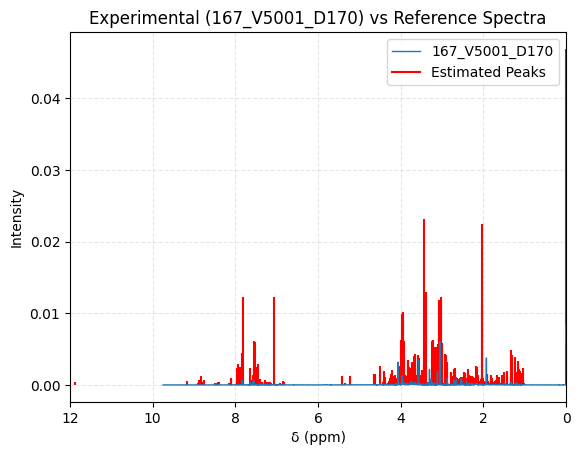

Removed components' spectra due to no matching peaks in mixture's spectrum: [3, 22, 27, 29, 52]
Envelope bounds: [(-1, -1, 3), (-1, -1, 22), (-1, -1, 27), (-1, -1, 29), (-1, -1, 52), (-0.0038, 191.5967, 4), (-0.0023, 47.4597, 14), (-0.001, 171.8986, 6), (-0.0001, 218.0914, 19), (0.0, 172.9516, 24), (0.0, 165.4828, 51), (0.001, 37.4039, 5), (0.001, 175.1177, 7), (0.0018, 184.1082, 0), (0.0027, 212.85, 18), (0.0857, 177.6724, 28), (0.9163818359375, 2.781097412109375, 45), (1.099136352539063, 5.327911376953125, 34), (1.144638061523438, 3.25982666015625, 17), (1.163, 11.882, 30), (1.280075073242188, 3.802215576171875, 37), (1.304000854492188, 4.147430419921875, 10), (1.304641723632813, 4.298995971679688, 39), (1.435592651367188, 3.870254516601563, 1), (1.504913330078125, 2.4544677734375, 20), (1.524246215820313, 3.870040893554688, 21), (1.563125610351563, 4.246124267578125, 46), (1.736053466796875, 4.312240600585938, 48), (1.893280029296875, 7.389747619628906, 12), (1.99774169921875, 3.821

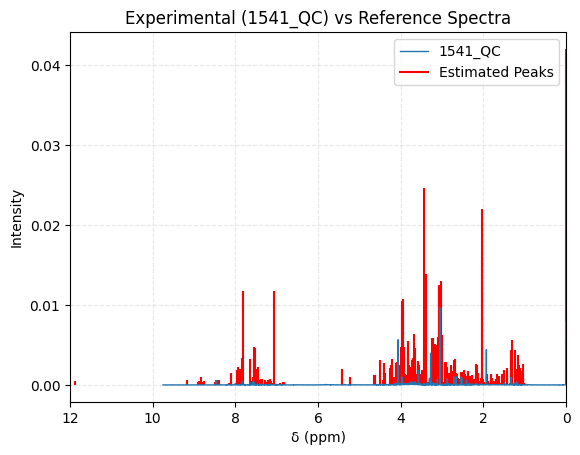

In [54]:
# zadanie 3.2

mix3 = experimental_spectra[23] # dzień 30
mix4 = experimental_spectra[9] # dzień 170

kappa_mixture = 0.3
kappa_components = 0.22

solver = pl.MOSEK(msg=False)

estimation_result_area_mosek = estimate_proportions(spectrum = mix3,
                                         query = new_spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix3, new_spectra, estimation_result_area_mosek['proportions'], 0, 12)


estimation_result_area_mosek = estimate_proportions(spectrum = mix4,
                                         query = new_spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(mix4, new_spectra, estimation_result_area_mosek['proportions'], 0, 12)


estimation_result_area_mosek = estimate_proportions(spectrum = QC,
                                         query = new_spectra,
                                         MTD = kappa_mixture,
                                         MTD_th = kappa_components,
                                         solver = solver,
                                         verbose=True,
                                         what_to_compare = 'area',
                                         )

draw_estimation_result(QC, new_spectra, estimation_result_area_mosek['proportions'], 0, 12)